# Analysis of Unspliced Reads

In [96]:
from datetime import date
print('created 2024-05-06')
print("last updated", date.today())

created 2024-05-06
last updated 2025-01-23


In this notebook I will examine the reads which were flagged as GFP unspliced. 

Each read is first parsed by its index into which sample it came from. Then the first 6nt at the 5' end are compared to the expected sequence for GFP or dTomato (marked by ^). If the first 6nt match either reporter with ≤1 mismatch, that read is called GFP or dTomato, otherwise it is discarded. If the read is classified as GFP I then examine bases 19-26, which I expect to be downstream of the exon-exon junction (marked with ||). I compare these to the expected sequence of the spliced mRNA (marked by *). If the sequence does not match with ≤1 error the read is classified as unspliced.

```html
  spliced: TGATCGTCGTCACCAG||GTGTCGTGAAHHHHHHHHHH...
unspliced: TGATCGTCGTCACCAG  gtgagtagcgggnnnnnnnn...
  dTomato: GCTAGCTCGTGATTCAG GTGTCGTGAAHHHHHHHHHH...
           ^^^^^^               *******


In [2]:
# imports

import sys
import pickle
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib import colors

from scipy import stats
from scipy.stats import spearmanr
from Levenshtein import distance as lev

sys.path.append("/Users/emmakowal/Dropbox (MIT)/Lab/Cluster/IME/scripts")
from functions import *
from constants import *

# aesthetics

%matplotlib inline
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.weight'] = 'regular'
plt.rcParams['figure.dpi']= 200

sns.set_palette("husl", 5)
def nicecolors(n, m=5):
    return sns.color_palette("husl", m)[n]

# path to i/o:
outpath = '/Users/emmakowal/Dropbox (MIT)/Lab/Notebooks/docs/'
IME_path = outpath+'../../Cluster/IME/'

In [3]:
# load in barcode-to-intron dictionary from round 2 (bottlenecked)
with open(outpath+'pkls/b2i_06_with_spikeins_and_flanking_seq_min3readclusters.pkl', 'rb') as f:
    b2i_06 = pickle.load(f)

# load in list of barcodes deemed trustworthy by mismatch analysis
with open(outpath+'pkls/06_4_barcodes_with_less_than_10_percent_reads_mismatched_v3_min3readclusters.pkl', 'rb') as f:
    bcs_to_keep = pickle.load(f)

# final b2i contains trustworthy barcodes only
b2i = {b:b2i_06[b] for (mismatch_rate, b) in bcs_to_keep}

In [4]:
# load in unspliced reads
RIL2_unspliced_dicts = {f'{c}_{i}':{} for c in ['canonical','cryptic'] for i in [1,2]}

for i in [1,2]:
    for c in ['canonical','cryptic']:
        with open(outpath+f'data/reads/RIL2_{i}_{c}_unspliced_dict_both_reads.pkl', 'rb') as f:
            RIL2_unspliced_dicts[f'{c}_{i}'] = pickle.load(f)

# merge into one dict to analyze all together
RIL2_unspliced_merge = {b:[] for b in b2i}

for R_dict in RIL2_unspliced_dicts.values():
    for b in R_dict:
        if b in b2i:
            RIL2_unspliced_merge[b].append(R_dict[b])

for b in b2i:
    if len(RIL2_unspliced_merge[b])==0:
        del RIL2_unspliced_merge[b]
    else:
        RIL2_unspliced_merge[b] = flatten(RIL2_unspliced_merge[b])
        
# how many barcodes are there here?
len(RIL2_unspliced_merge)

12048

In [5]:
# how many reads are there?
len(flatten([x for x in RIL2_unspliced_merge.values()]))

1276616

# validation of barcode-intron mapping via unspliced reads

a mismapped intron will have the expected constant 5'SS and 3'SS sequence, but different than expected sequence in the variable region. we can split each read into 6 regions and get the lev dist observed/expected for each in order to specifically highlight reads that map in the constant region and not the variable region.

In [6]:
# generate a list of tuples representing the lev distance between observed and expected seq
# for each reverse (5' end of amplicon) and forward (3' end, must take reverse complement) read pair

lengths = [16, 12, 16, 4, 40, 10]
RIL2_unspliced_errors = {b:[] for b in RIL2_unspliced_merge}
RIL2_unspliced = {b:[] for b in RIL2_unspliced_merge}
exon1 = 'TGATCGTCGTCACCAG'
fiveSS_seq = 'GTGAGTAGCGGG'
threeSS_seq = 'GCCTCAGACAGTGGTTCAAAGTTTTTTTCTTCCATTTCAG'
exon2 = 'GTGTCGTGAA' 
actually_spliced = []

for bc, reads in RIL2_unspliced_merge.items():
    expected_5end = b2i[bc][12:28]
    expected_3end = b2i[bc][-44:-40]
    for read in reads:
        fread = read[0]
        rread = read[1]
        exon1_score = lev(rread[:16], exon1)
        SS_score5 = lev(rread[16:28], fiveSS_seq)
        dist5 = lev(rread[28:], expected_5end)
        dist3 = lev(rc(fread)[:4], expected_3end)
        SS_score_3 = lev(rc(fread)[4:44], threeSS_seq)
        exon2_score = lev(rc(fread)[44:54], exon2)
        maybe_spliced = lev(rread[16:28], exon2+bc[:2])
        if maybe_spliced <=2:
            actually_spliced.append(bc)
        else:
            RIL2_unspliced_errors[bc].append([exon1_score,SS_score5,dist5,dist3,SS_score_3,exon2_score])
            RIL2_unspliced[bc].append(read)

In [7]:
for bc in list(RIL2_unspliced_merge.keys()):
    if len(RIL2_unspliced[bc]) == 0:
        del RIL2_unspliced[bc]
    if len(RIL2_unspliced_errors[bc]) == 0:
        del RIL2_unspliced_errors[bc]

In [8]:
# how many reads were, in fact, probably correctly spliced?
print(len(actually_spliced))

76602


In [9]:
# how many barcodes are there now?
len(RIL2_unspliced)

11934

In [10]:
# how many reads are there now?
len(flatten([x for x in RIL2_unspliced.values()]))

1200014

In [11]:
# what is the sequencing error rate that we expect 
# from looking at exonic sequence?

exon_error_rates = []
for bc, read_errors in RIL2_unspliced_errors.items():
    exon_error_rates.append([e[0]/16 for e in read_errors])    # exon 1
    exon_error_rates.append([e[5]/10 for e in read_errors])    # exon 2
exon_error_rates = np.array(flatten(exon_error_rates))

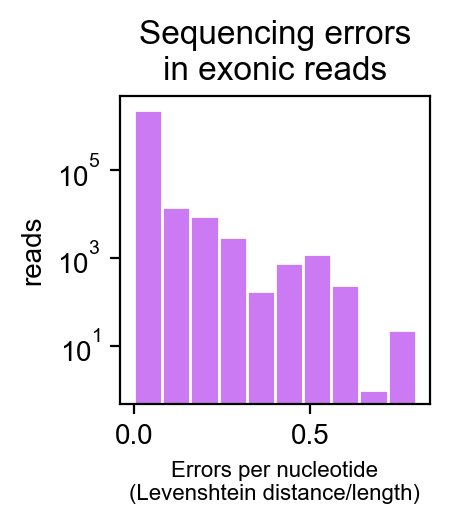

mean: 0.0027
99th percentile: 0.1, or 1 in 10.0


In [12]:
hist_data = exon_error_rates
plt.figure(figsize=(2,2))
plt.hist(hist_data, #bins=20,  
         edgecolor='w', facecolor=nicecolors(4))
plt.xlabel('Errors per nucleotide\n(Levenshtein distance/length)', fontsize=8)
plt.ylabel('reads')
plt.title('Sequencing errors\nin exonic reads')
plt.yscale('log')
plt.show()

# what is the mean error rate?
print(f'mean: {exon_error_rates.mean():.4f}')

# what is the 99th percentile error count?
perc_99 = np.percentile(exon_error_rates, 99)
print(f'99th percentile: {perc_99}, or 1 in {1/perc_99}')

We will use this as the maximum acceptable error to call a sequence "correct" or "expected".

With this threshold, how many reads have the correct constant regions, but incorrect variable regions? 

In [13]:
lengths = [16, 12, 16, 4, 40, 10]
max_errs = [round(n*perc_99) for n in lengths]
max_errs

[2, 1, 2, 0, 4, 1]

In [14]:
RIL2_correct_SS_intron_dists = {bc:[] for bc in RIL2_unspliced_errors}

for bc, reads in RIL2_unspliced_errors.items():
    for i, read in enumerate(reads):
       if read[1]<=max_errs[1] & read[4]<=max_errs[4]:
           RIL2_correct_SS_intron_dists[bc].append((read[2],read[3]))
    if len(RIL2_correct_SS_intron_dists[bc])==0:
        del RIL2_correct_SS_intron_dists[bc]

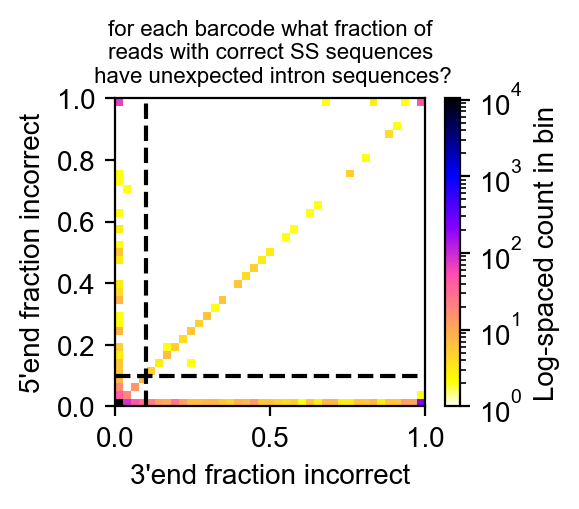

In [15]:
# set max error tolerances for calling read a match
# then compute fraction of matching reads per barcode

tol5 = max_errs[2]
tol3 = max_errs[3]

#data = np.array(flatten(RIL2_correct_SS_intron_dists.values()))

dlists = list(RIL2_correct_SS_intron_dists.items())
bcs = [bc for bc,dlist in dlists]
data = np.array([(np.sum([d[0]>tol5 for d in dlist])/len(dlist),
                  np.sum([d[1]>tol5 for d in dlist])/len(dlist)) for bc,dlist in dlists])
dists5 = data[:, 0]
dists3 = data[:, 1]

bins = (np.linspace(0, 1, 40),
        np.linspace(0, 1, 40))
counts, xedges, yedges = np.histogram2d(dists3, dists5, bins=bins)
counts[counts == 0] = 1

plt.figure(figsize=(2.5,2))
hist = plt.hist2d(dists3,dists5, bins=bins, 
                  cmap='gnuplot2_r', 
                  norm=mpl.colors.LogNorm(vmin=counts.min(), vmax=counts.max())
                 )

plt.colorbar(hist[3], label='Log-spaced count in bin')
plt.xlabel('3\'end fraction incorrect')
plt.ylabel('5\'end fraction incorrect')
#plt.title('3\' vs 5\' intron error rates per barcode\n for reads with correct splice site sequences', fontsize=10)
plt.title('for each barcode what fraction of\nreads with correct SS sequences\n have unexpected intron sequences?', fontsize=8)

tol = 0.1
plt.axvline(tol, c='k',linestyle='--')
plt.axhline(tol, c='k',linestyle='--')

# Boolean masks for conditions
error3 = dists3 > tol
ok3 = dists3 <= tol
error5 = dists5 > tol
ok5 = dists5 <= tol

# Calculate the counts for each quadrant
q1 = (error3 & error5).sum()
q2 = (ok3 & error5).sum()
q3 = (ok3 & ok5).sum()
q4 = (error3 & ok5).sum()

plt.annotate(f'{q1*100/len(data):.1f}%', xy=(tol+1.5,tol+2), fontsize=8)
plt.annotate(f'{q2*100/len(data):.1f}%', xy=(tol+0.2,tol+2), fontsize=8)
plt.annotate(f'{q3*100/len(data):.1f}%', xy=(tol+0.2,tol-0.5), fontsize=8)
plt.annotate(f'{q4*100/len(data):.1f}%', xy=(tol+1.5,tol-0.5), fontsize=8)

plt.show()

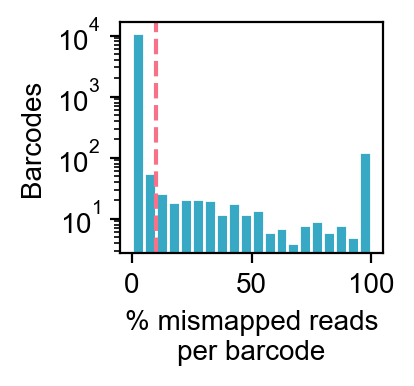

In [16]:
hist_data=dists5
t = tol
plt.figure(figsize=(1.7,1.5))
plt.hist(hist_data*100, bins=20,
         edgecolor='w', facecolor=nicecolors(3))
#plt.title(f'mean 5\' end edit distance per barcode\nfor reads with correct splice site sequences\n', fontsize=8)
#plt.title('rates of barcode-intron mismapping', fontsize=8)
plt.xlabel('% mismapped reads\nper barcode')
plt.ylabel('Barcodes')
plt.axvline(t*100, linestyle='--')
#plt.annotate(f'{(hist_data<=t).sum()*100/len(hist_data):.1f}%', xy=((t*0.8)-2,8000), fontsize=8)
#plt.annotate(f'{(hist_data>t).sum()*100/len(hist_data):.1f}%', xy=(t+2,8000), fontsize=8)
plt.yscale('log')
#plt.ylim(0,11000)
#plt.xticks(np.arange(0,18,2))
plt.savefig('figures/fig3E2.png', dpi=900, bbox_inches='tight')
plt.show()

### what do reads from putatively mismapped bcs look like?

In [17]:
mismapped_bcs = np.array(bcs)[error5]
len(mismapped_bcs)

340

In [18]:
from collections import Counter

plus11 = []
to_print = 10
printed = 0

for bc in mismapped_bcs:
    expected_5end = b2i[bc][12:28]
    expected_3end = b2i[bc][-44:-40]
    list_of_int_reads = [(x[1][28:], rc(x[0])[:4]) for x in RIL2_unspliced[bc]]
    readcounts = Counter(list_of_int_reads)
    top_read, top_count = readcounts.most_common(1)[0]
        
    if printed<to_print:
        print(f'\nbc: {bc}')
        print(f'    exp: {expected_5end}    {expected_3end}')
        print(f'    obs: {top_read[0]}    {top_read[1]}')
        print(f'    dists: {lev(expected_5end,top_read[0])}               {lev(expected_3end,top_read[1])}')
        print(f'    +11 5\'SS? {lev(top_read[0],exon2+bc[:6])<=2}')
        print(f'    count: {top_count}/{len(list_of_int_reads)}')
        print()
        printed+=1

    if lev(top_read[0],exon2+bc[:6])<=2:
        plus11.append(bc)
    elif len(readcounts)>1:
        top_read2, top_count2 = readcounts.most_common(2)[1]
        if lev(top_read2[0],exon2+bc[:6])<=2:
            plus11.append(bc)
        if printed<to_print:
            print(f'    exp: {expected_5end}    {expected_3end}')
            print(f'    obs: {top_read2[0]}    {top_read2[1]}')
            print(f'    dists: {lev(expected_5end,top_read2[0])}               {lev(expected_3end,top_read2[1])}')
            print(f'    +11 5\'SS? {lev(top_read2[0],exon2+bc[:6])<=2}')
            print(f'    count: {top_count2}/{len(list_of_int_reads)}')
            print()


bc: TTCAATCTTTACCTTACC
    exp: TCCGTTACTTTAATCT    TTTA
    obs: TCCGTTACTTTAATCT    GTTT
    dists: 0               2
    +11 5'SS? False
    count: 3/4

    exp: TCCGTTACTTTAATCT    TTTA
    obs: TGTCGTGAATTCAATC    TTGT
    dists: 6               2
    +11 5'SS? True
    count: 1/4


bc: TAACTACACATTCCCAAA
    exp: TACGTACCAACCTGGT    TCGT
    obs: TGTCGTGAATAACTAC    TTGT
    dists: 9               1
    +11 5'SS? True
    count: 67/105


bc: CCCTTATAATCTTTCTTT
    exp: TGCGTACTATATTGCC    AAGG
    obs: TGCGTACTATATTGCC    CAAG
    dists: 0               2
    +11 5'SS? False
    count: 194/258

    exp: TGCGTACTATATTGCC    AAGG
    obs: TGTCGTGAACCCTTAT    TTGT
    dists: 10               3
    +11 5'SS? True
    count: 60/258


bc: CAATCTATCTTCCCTTTT
    exp: ATCCCTAGAGCTTGCA    GAAG
    obs: TTGGTCTGCCCTTCAA    ACCG
    dists: 9               3
    +11 5'SS? False
    count: 42/44

    exp: ATCCCTAGAGCTTGCA    GAAG
    obs: TTGGTCTGCCCTTCAA    ACTG
    dists: 9               3

In [19]:
# how many of the "mismapped" bcs are actually cryptic splicing with +11 G?
len(plus11)

138

In [20]:
truly_mismapped_bcs = [x for x in mismapped_bcs if x not in plus11]

In [21]:
((hist_data>t).sum()/len(hist_data))

0.029728075544286088

In [22]:
(hist_data<=t).sum()

11097

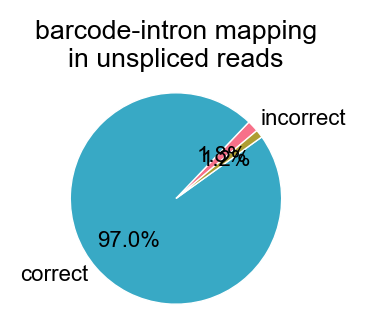

In [23]:
# modify with bcs identified as cryptically spliced to +11 G in manual examination:

labels = ['incorrect','correct','']
sizes = [((hist_data>t).sum()-len(plus11))*100/len(hist_data),
        ((hist_data<=t).sum())*100/len(hist_data),
        len(plus11)*100/len(hist_data)]
colors = [nicecolors(i) for i in [0,3,1]]
explode = (0, 0, 0)
mpl.rcParams['font.size'] = 8

plt.figure(figsize=(1.5,1.5))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', #shadow=True, 
        startangle=40, wedgeprops={'edgecolor': 'w','linewidth':0.5})
plt.title('barcode-intron mapping\nin unspliced reads')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

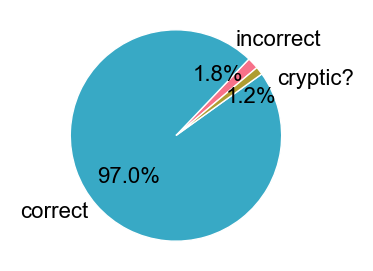

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Custom function to format the labels
def format_pct(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%"

labels = ['incorrect','correct','cryptic?']
sizes = [((hist_data>t).sum()-len(plus11))*100/len(hist_data),
        ((hist_data<=t).sum())*100/len(hist_data),
        len(plus11)*100/len(hist_data)]
colors = [nicecolors(i) for i in [0,3,1]]
explode = (0, 0, 0)
mpl.rcParams['font.size'] = 8

plt.figure(figsize=(1.5, 1.5))
wedges, texts, autotexts = plt.pie(sizes, explode=explode, labels=labels, colors=colors,
                                   autopct=lambda pct: format_pct(pct, sizes), 
                                   startangle=40, wedgeprops={'edgecolor': 'w', 'linewidth': 0.5})

texts[0].set_position((0.7 * texts[0].get_position()[0], 1.2 * texts[0].get_position()[1]))
texts[2].set_position((1.1 * texts[2].get_position()[0], 0.8 * texts[2].get_position()[1]))
autotexts[0].set_position((0.9 * autotexts[0].get_position()[0], 1.4 * autotexts[0].get_position()[1]))
autotexts[2].set_position((1.5 * autotexts[2].get_position()[0], 1.0 * autotexts[2].get_position()[1]))

#plt.title('barcode-intron mapping\nin unspliced reads', fontsize=8)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig('figures/fig3E1.png', dpi=900, bbox_inches='tight')
plt.show()


In [25]:
to_print = 6
printed = 0

for bc in truly_mismapped_bcs:
    expected_5end = b2i[bc][12:28]
    expected_3end = b2i[bc][-44:-40]
    list_of_int_reads = [(x[1][28:], rc(x[0])[:4]) for x in RIL2_unspliced[bc]]
    readcounts = Counter(list_of_int_reads)
    top_read, top_count = readcounts.most_common(1)[0]
        
    if printed<to_print:
        print(f'\nbc: {bc}')
        print(f'    exp: {expected_5end}    {expected_3end}')
        print(f'    obs: {top_read[0]}    {top_read[1]}')
        print(f'    dists: {lev(expected_5end,top_read[0])}               {lev(expected_3end,top_read[1])}')
        print(f'    count: {top_count}/{len(list_of_int_reads)}')
        print()
        printed+=1

    if len(readcounts)>1:
        top_read2, top_count2 = readcounts.most_common(2)[1]
        if printed<to_print:
            print(f'    exp: {expected_5end}    {expected_3end}')
            print(f'    obs: {top_read2[0]}    {top_read2[1]}')
            print(f'    dists: {lev(expected_5end,top_read2[0])}               {lev(expected_3end,top_read2[1])}')
            print(f'    count: {top_count2}/{len(list_of_int_reads)}')
            print()


bc: CAATCTATCTTCCCTTTT
    exp: ATCCCTAGAGCTTGCA    GAAG
    obs: TTGGTCTGCCCTTCAA    ACCG
    dists: 9               3
    count: 42/44

    exp: ATCCCTAGAGCTTGCA    GAAG
    obs: TTGGTCTGCCCTTCAA    ACTG
    dists: 9               3
    count: 1/44


bc: TTTCCTCATTTCACCCCC
    exp: AGTACCAAGGTCCGGT    CTCC
    obs: CCAAGACAGTTTCGAA    CTCC
    dists: 10               0
    count: 179/346

    exp: AGTACCAAGGTCCGGT    CTCC
    obs: AGTACCAAGGTCCGGT    CTCC
    dists: 0               0
    count: 122/346


bc: TAAACTCTACTTTACTAA
    exp: TACGCTTAGCTCGGAT    GGGT
    obs: AAGGGGAATTGAAACT    GCAT
    dists: 11               2
    count: 23/23


bc: CTCACCACATTTACCCCC
    exp: CGTGCACTGACGACTG    GCCG
    obs: CGTGCACTGACGACTG    CGCG
    dists: 0               2
    count: 247/411

    exp: CGTGCACTGACGACTG    GCCG
    obs: CTTATGTCAGTCTGTT    GAGA
    dists: 9               3
    count: 73/411


bc: TTCTCAAAAAAACACAAT
    exp: ACCCTCCTTTTATGGA    TGGC
    obs: ACCCTCCTTTTATGGA    TGGC

# analysis of splicing heterogeneity in unspliced reads

My primary goal for this analysis is to classify each unspliced read as one of 3 possible events: 

1. canonical unspliced (i.e. expected pre-mRNA sequence for that intron, or close enough to be seq error)
2. cryptic 5' or 3' splicing event (and examine in more detail how this may be occurring)
3. barcode-intron mapping error

What would an unspliced read with NO cryptic splicing look like?
- the 5'->3' read (actually the reverse read in the seq scheme, though I will refer to it as the 5' read to avoid confusion) should contain the constant 5'SS plus the beginning of the 5' end of the random region of the intron
- the 3'->5' read begins with the sample index and extends 54 bases past the barcode. in a true unspliced read, this will be 10 bases of spacer, 40 bases of constant 3'SS, and 4 bases of the 3' end of the intron random region.

example read pair for barcode TTTTTTTTCTTACATTTT:
```
  exon-intron boundary:                ||           ****************
               5' read: TGATCGTCGTCACCAGGTGAGTAGCGGGGTGCATTCGTACAGTT
expected 5'ss sequence:                 GTGAGTAGCGGGGTGCATTCGTACAGTT

  intron-exon boundary: ****                                       ||
               3' read: GTGTGCCTCAGACAGTGGTTCAAAGTTTTTTTCTTCCATTTCAGGTGTCGTGAATTTTTT...
expected 3'ss sequence: GTGTGCCTCAGACAGTGGTTCAAAGTTTTTTTCTTCCATTTCAG

```
(*** indicates random sequence)

note that this is indistinguishable from splicing of an internal intron with cryptic 5'SS *and* cryptic 3'SS if these SS are more than 22 bases and 44 bases into the random region, respectively. However, I believe this is unlikely.

As the first step, I will calculate for each read the Levenshtein distance between observed and expected sequences for all unspliced reads:

In [26]:
# generate a list of tuples representing the lev distance between observed and expected seq
# for each reverse (5' end of amplicon) and forward (3' end, must take reverse complement) read pair

RIL2_unspliced_dists = {b:[] for b in RIL2_unspliced}
fiveSS_seq = 'GTGAGTAGCGGG'
threeSS_seq = 'GCCTCAGACAGTGGTTCAAAGTTTTTTTCTTCCATTTCAG'

for bc, reads in RIL2_unspliced.items():
    expected_5seq = fiveSS_seq+b2i[bc][12:28]
    for read in reads:
        fread = read[0]
        rread = read[1]
        observed_5seq = rread[16:]
        observed_3seq = rc(fread)[4:44]
        dist5 = lev(expected_5seq, observed_5seq)
        dist3 = lev(threeSS_seq, observed_3seq)
        RIL2_unspliced_dists[bc].append((dist5,dist3))

In [27]:
# convert dict to lists for plotting

all_reads_dists = flatten([dlist for bc, dlist in RIL2_unspliced_dists.items()])
all_bcs_dlists = [np.array(dlist) for bc, dlist in RIL2_unspliced_dists.items()]
all_bcs_mean_dists = [(np.mean([d[0] for d in dlist]),np.mean([d[1] for d in dlist])) for dlist in all_bcs_dlists]

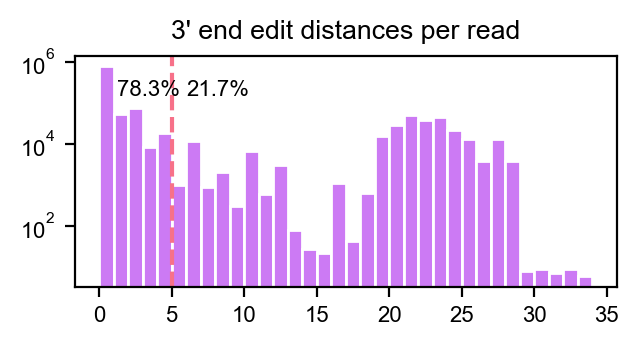

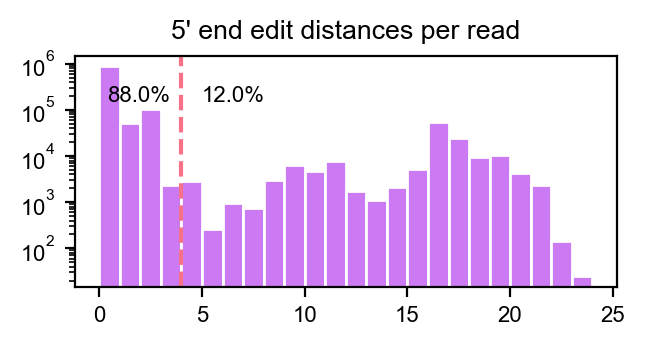

In [30]:
# set max error tolerances for calling read a match
# then compute fraction of matching reads per barcode

tol5 = round(perc_99*len(observed_5seq))
tol3 = round(perc_99*len(observed_3seq))

data = np.array(all_reads_dists)
dists5,dists3 = data[:, 0], data[:, 1]

for e,t,hist_data in [(3,tol3,dists3), (5,tol5,dists5)]:
    plt.figure(figsize=(3.5,1.5))
    plt.hist(hist_data, bins=np.arange(max(hist_data)), edgecolor='w', facecolor=nicecolors(4))
    plt.title(f'{e}\' end edit distances per read')
    #plt.ylim(0, 60000)
    plt.axvline(t+1, linestyle='--')
    plt.annotate(f'{(hist_data<=t).sum()*100/len(hist_data):.1f}%', xy=((t*0.8)-2,150000), fontsize=8)
    plt.annotate(f'{(hist_data>t).sum()*100/len(hist_data):.1f}%', xy=(t+2,150000), fontsize=8)
    plt.yscale('log')
    plt.show()


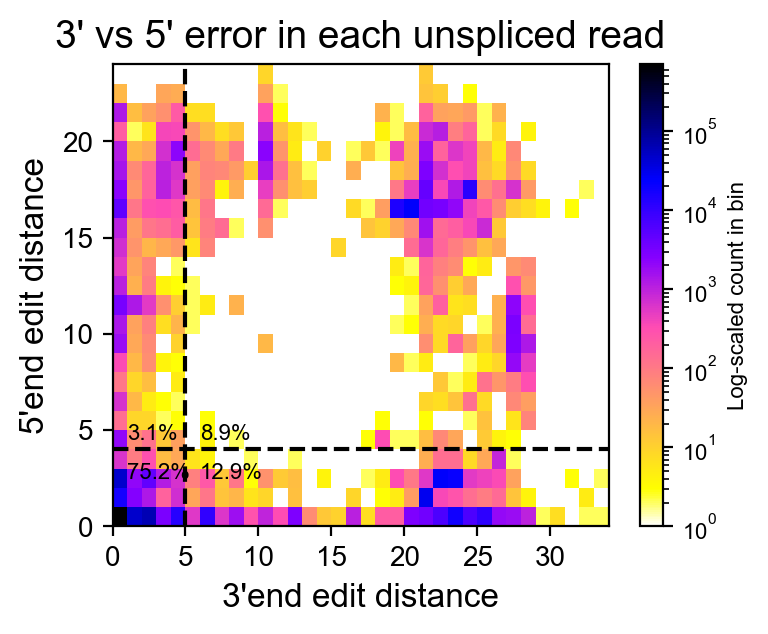

In [32]:
# plot 5' vs 3' error for all unspliced reads

bins = (np.arange(max(dists3)),
        np.arange(max(dists5)))
counts, xedges, yedges = np.histogram2d(dists3,dists5, bins=bins)
counts[counts == 0] = 1

plt.figure(figsize=(4,3))
hist = plt.hist2d(dists3,dists5, bins=bins, cmap='gnuplot2_r', 
                  norm=mpl.colors.LogNorm(vmin=counts.min(), vmax=counts.max()))

plt.colorbar(hist[3], label='Log-scaled count in bin')
plt.xlabel('3\'end edit distance', fontsize=12)
plt.ylabel('5\'end edit distance', fontsize=12)
plt.title('3\' vs 5\' error in each unspliced read', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.axvline(tol3+1, c='k',linestyle='--')
plt.axhline(tol5+1, c='k',linestyle='--')

# Boolean masks for conditions
error3 = dists3 > tol3
ok3 = dists3 <= tol3
error5 = dists5 > tol5
ok5 = dists5 <= tol5

# Calculate the counts for each quadrant
q1 = (error3 & error5).sum()
q2 = (ok3 & error5).sum()
q3 = (ok3 & ok5).sum()
q4 = (error3 & ok5).sum()

plt.annotate(f'{q1*100/len(data):.1f}%', xy=(tol3+2,tol5+1.5), fontsize=8)
plt.annotate(f'{q2*100/len(data):.1f}%', xy=(tol3-3,tol5+1.5), fontsize=8)
plt.annotate(f'{q3*100/len(data):.1f}%', xy=(tol3-3,tol5-0.5), fontsize=8)
plt.annotate(f'{q4*100/len(data):.1f}%', xy=(tol3+2,tol5-0.5), fontsize=8)

plt.savefig('figures/fig4C.png', dpi=900, bbox_inches='tight')

plt.show()

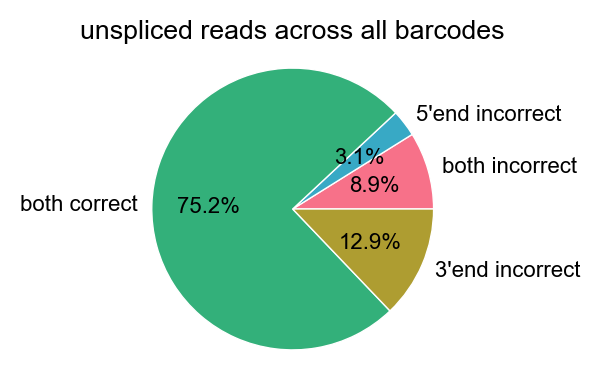

In [33]:
labels = ['both incorrect','5\'end incorrect','both correct','3\'end incorrect']
sizes = [q1,q2,q3,q4]
colors = [nicecolors(i) for i in [0,3,2,1]]
explode = (0, 0, 0, 0)
mpl.rcParams['font.size'] = 8

plt.figure(figsize=(2,2))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', #shadow=True, 
        startangle=0, wedgeprops={'edgecolor': 'w','linewidth':0.5})
plt.title('unspliced reads across all barcodes')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

So about 75% of unspliced reads fit the description of a read that is simply unspliced, but the barcode maps to the correct intron sequence and both ends of the read contain the expected splice sites. 

How are these reads distributed among barcodes?

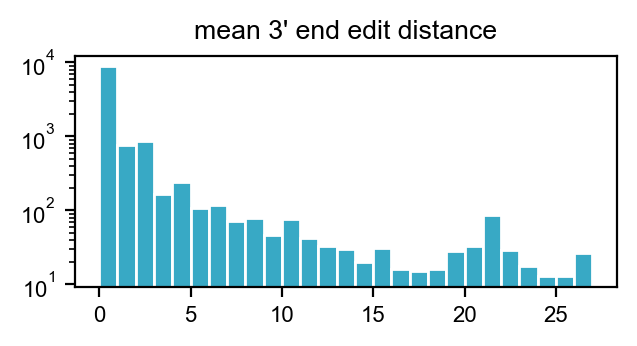

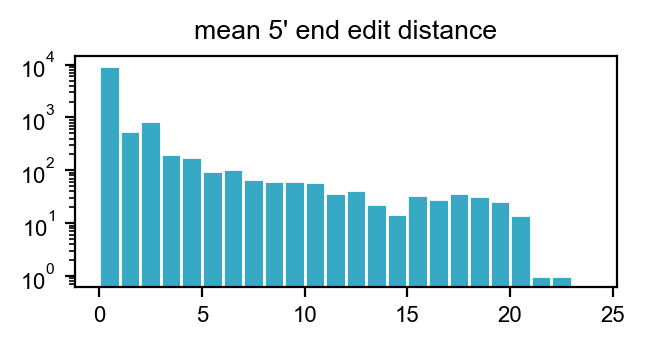

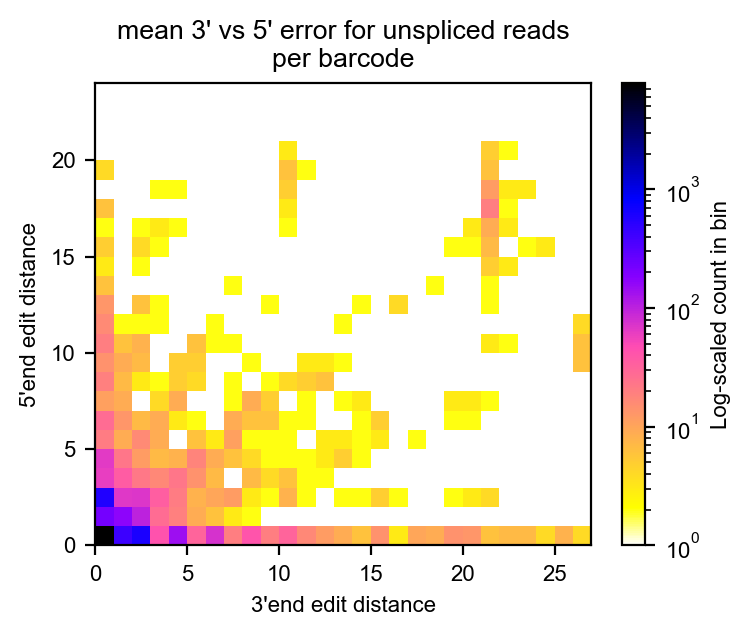

In [34]:
ydata,xdata = zip(*all_bcs_mean_dists)

for e,data in [(3,xdata), (5,ydata)]:
    plt.figure(figsize=(3.5,1.5))
    plt.hist(data, bins=np.arange(max(data)), edgecolor='w', facecolor=nicecolors(3))
    plt.title(f'mean {e}\' end edit distance')
    #plt.ylim(0,500)
    plt.yscale('log')
    plt.show()

bins = (np.arange(max(xdata)),
        np.arange(max(ydata)))
counts, xedges, yedges = np.histogram2d(xdata,ydata, bins=bins)
counts[counts == 0] = 1

plt.figure(figsize=(4,3))
hist = plt.hist2d(xdata,ydata, bins=bins, cmap='gnuplot2_r', 
                  norm=mpl.colors.LogNorm(vmin=counts.min(), vmax=counts.max()))

plt.colorbar(hist[3], label='Log-scaled count in bin')

plt.xlabel('3\'end edit distance')
plt.ylabel('5\'end edit distance')
plt.title('mean 3\' vs 5\' error for unspliced reads\nper barcode')
plt.show()

In [35]:
# plot fraction of unspliced reads which look correct per barcode
bc_ok_fractions = {b:-1 for b in RIL2_unspliced}

for bc, dlist in RIL2_unspliced_dists.items():
    if len(dlist)>1:
        dlist = np.array(dlist)
        ok5 = dlist[:,0] <= tol5
        ok3 = dlist[:,1] <= tol3
        ok = (ok3&ok5).sum()
        ok_fraction = ok/len(dlist)
        bc_ok_fractions[bc] = ok_fraction
    else:
        del bc_ok_fractions[bc]

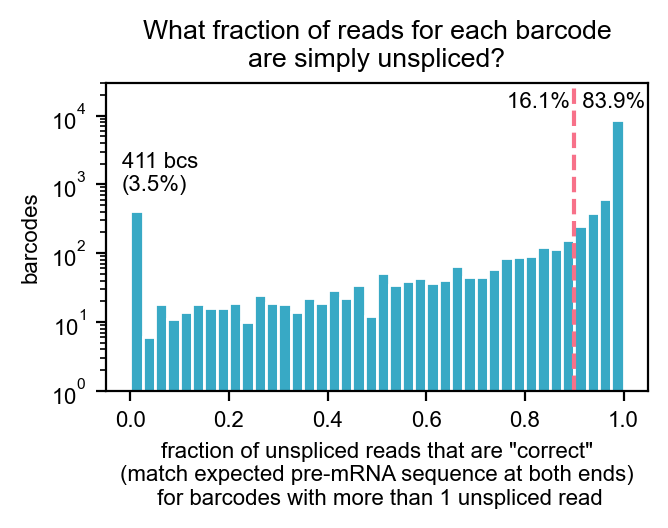

In [36]:
hist_data = bc_ok_fractions.values()

plt.figure(figsize=(3.5,2))
plt.hist(hist_data, bins=40,  
         edgecolor='w', facecolor=nicecolors(3))
plt.xlabel('fraction of unspliced reads that are "correct"\n(match expected pre-mRNA sequence at both ends)\n for barcodes with more than 1 unspliced read', fontsize=8)
plt.ylabel('barcodes')
plt.title('What fraction of reads for each barcode\nare simply unspliced?')

frac_bcs_ok = len([x for x in hist_data if x>=0.9])/len(hist_data)
plt.axvline(0.9,linestyle='--') 
plt.annotate(f'{(1-frac_bcs_ok)*100:.1f}%  {(frac_bcs_ok)*100:.1f}%',
             xy=(0.74,0.92), xycoords='axes fraction', fontsize=8)
num_always_wrong = len([x for x in hist_data if x<0.02])
plt.annotate(f'{num_always_wrong} bcs\n({num_always_wrong*100/len(hist_data):.1f}%)',
             xy=(0.03,0.65), xycoords='axes fraction', fontsize=8)
plt.yscale('log')
plt.ylim(1,30000)
plt.show()

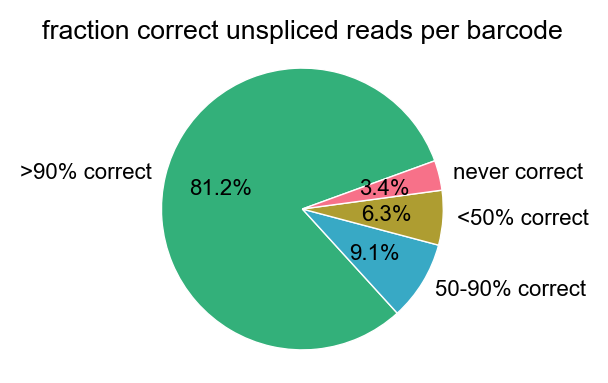

In [37]:
hist_data = bc_ok_fractions.values()

labels = ['>90% correct','50-90% correct','<50% correct','never correct']
sizes = [len([x for x in hist_data if x>=0.9]),
        len([x for x in hist_data if (x>0.5)&(x<0.9)]),
        len([x for x in hist_data if x<0.5]),
        len([x for x in hist_data if x<0.02])]
colors = [nicecolors(i) for i in [2,3,1,0]]
explode = (0, 0, 0, 0)
mpl.rcParams['font.size'] = 8

plt.figure(figsize=(2,2))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', #shadow=True, 
        startangle=20, wedgeprops={'edgecolor': 'w','linewidth':0.5})
plt.title('fraction correct unspliced reads per barcode')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

79% of barcodes have the predicted pre-mRNA sequence in >=90% of their reads, while about 20% show some appreciable level of cryptic splicing or other unexpected sequence; 3% of these (351 barcodes) have some unexpected sequence in ALL of their unspliced reads

# What would a cryptically spliced intron with an internal 5'SS look like?

Next I will try to identify instances of cryptic splicing in the unspliced reads that do not look like the predicted mRNA sequence.

- since the 3' read goes 44nt into the 3'end of the intron, if there is a cryptic 5'SS that uses the canonical 3'SS, we will see 44nt of the new exon upstream of this cryptic 5'SS spliced to the canonical exon 2, and can use this to identify the location of the cryptic splice site.
 
the logic we can use to find these cryptic splice sites could be as follows:
- for any read with unexpected sequence at the 3' end, take terminal 20 bases of intron from read and scan across the predicted intron from barcode, compute lev distances with each window
- if you find a single position with the minimum score in all reads, store those 20 bases plus the next 20 in the intron
- what minimum score is low enough? two random sequences will on average match at 1/4 positions, which would give lev 16 in a 20nt window, but these are not random sequences (i mean, they are, but...) because they will be biased for nucleotides that give a good upstream 5'SS context. also, more importantly, we are testing every window in the intron and taking the minimum, so we are sampling from that random x random distribution ~150 times and by chance will encounter some better matches. so we should probably be conservative about this and say mean score at best position across all reads has to be <4

In [38]:
# get dict of all unexpected 3' end seqs

alt_3_seqs = {bc:[] for bc in RIL2_unspliced}

for bc in RIL2_unspliced.keys():
    dlist = RIL2_unspliced_dists[bc]
    # save any 3'end seqs (the 44 nucleotides in the intron) that do not match expected seq
    alt_seqs = [rc(s[0])[:44] for i,s in enumerate(RIL2_unspliced[bc]) if dlist[i][1] > tol3]
    alt_3_seqs[bc].append(alt_seqs)
    
for b in RIL2_unspliced:
    alt_3_seqs[b] = flatten(alt_3_seqs[b])
    if len(alt_3_seqs[b])==0:
        del alt_3_seqs[b]   

starting with 260988 reads from 3798 barcodes
2256 barcodes have at least 2 unspliced reads with unexpected intron 3' end seq
checking for potential alternative 5'SSs...


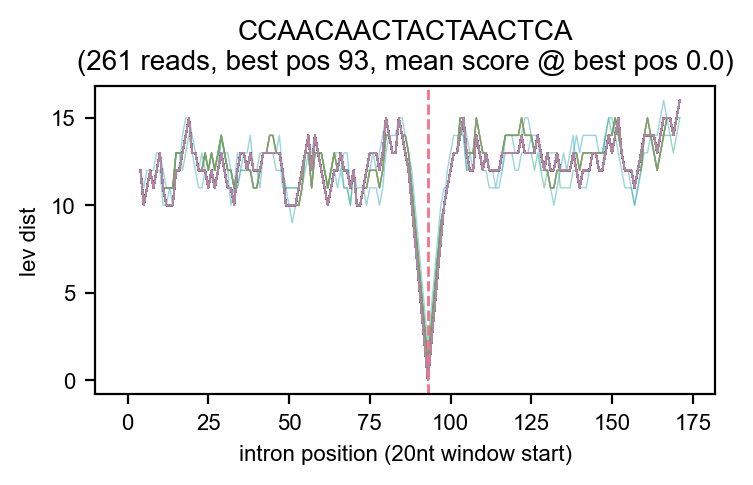

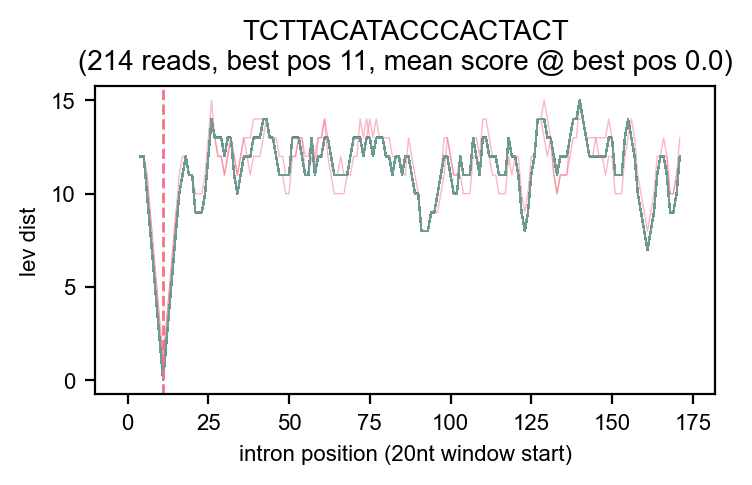

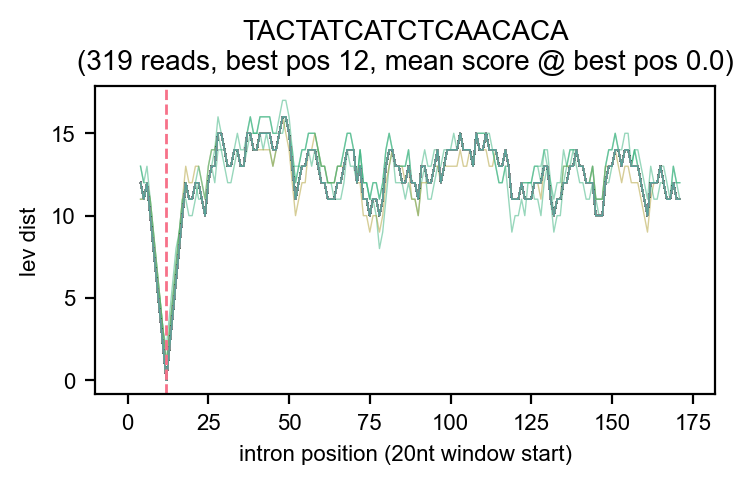

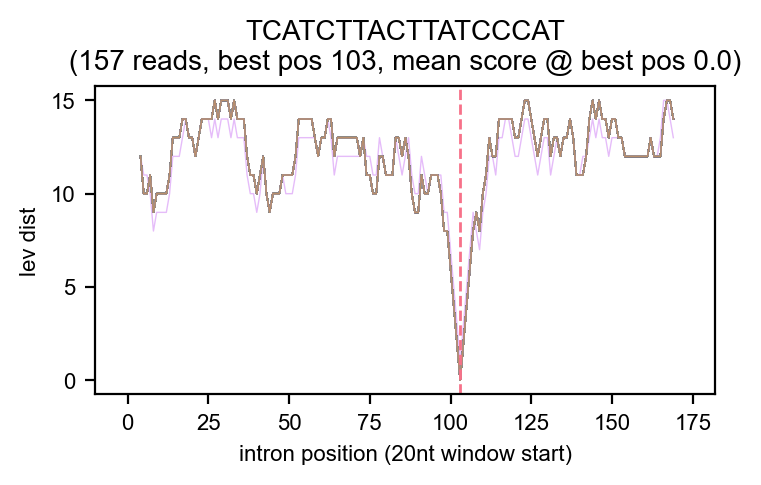

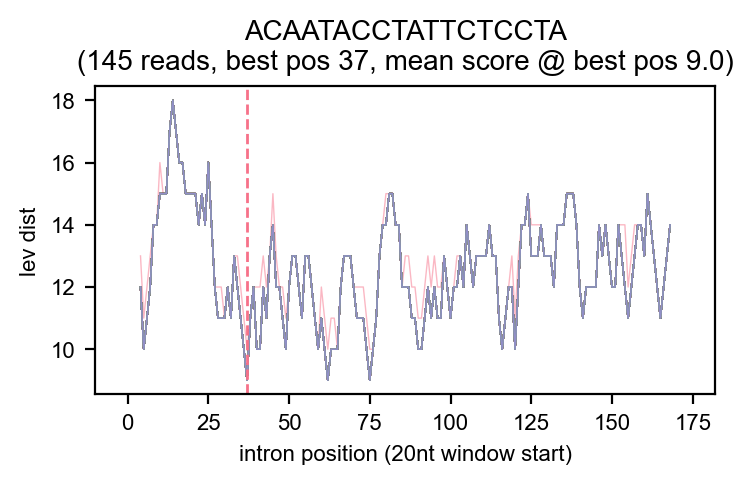

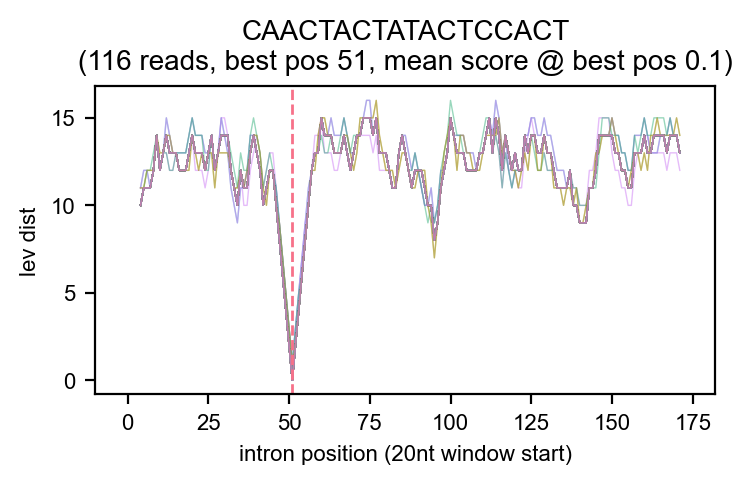

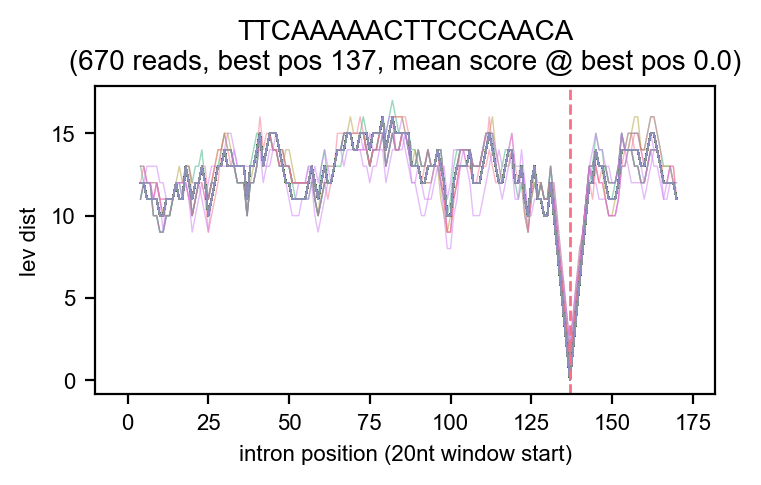

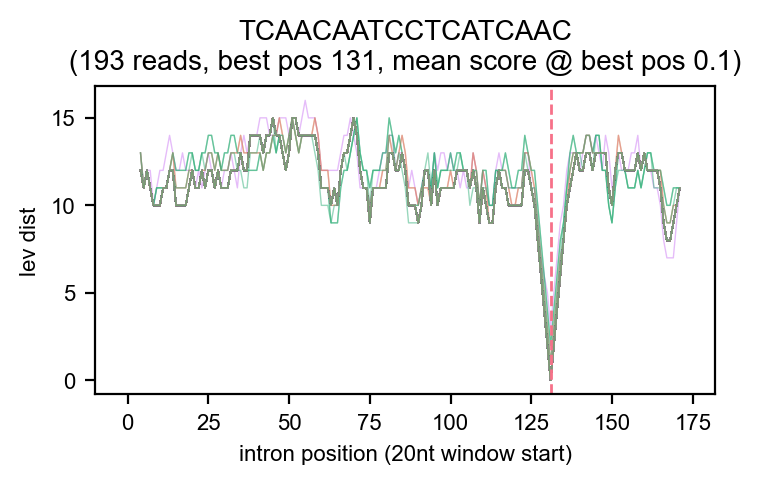

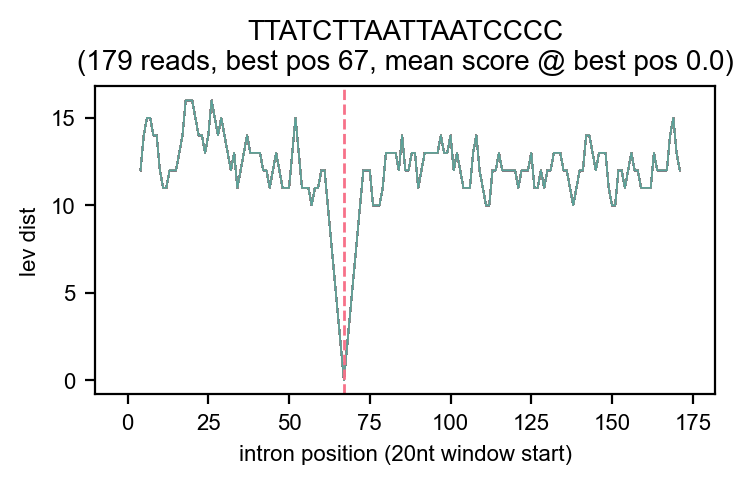

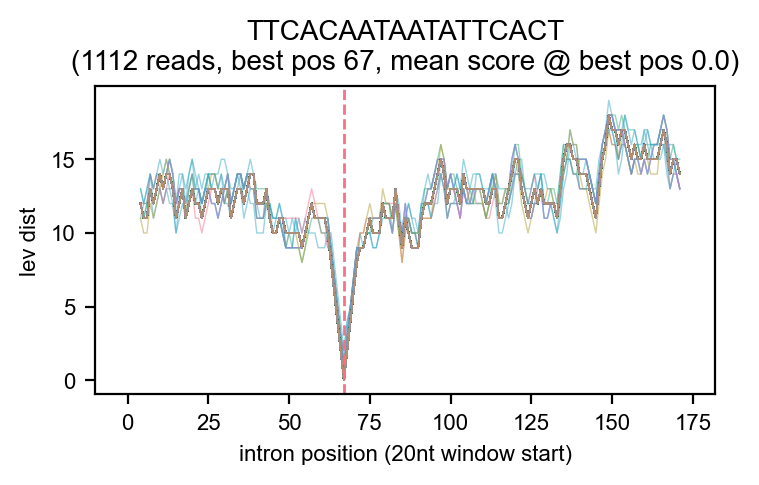

1251 of these barcodes have a single position in the intron that seems to be used as a 5'SS


In [44]:
# take the last n bases of intron from read and scan across the predicted intron to see lev distances with any given window
# if there is one position with min lev in all reads,
# store those n bases plus the next 10 in the intron

# length of read to use to scan along intron for homology
window_size = 20
exon1 = 'TGATCGTCGTCACCAG'    #add 16nt upstream exon seq to allow for possibility of SS in this region
exon2 = 'GTGTCGTGAA'    # same logic at 3' end
shift = window_size-len(exon1)

print(f'starting with {len(flatten([x for x in alt_3_seqs.values()]))} reads from {len(alt_3_seqs)} barcodes')
bcs_of_interest = [b for b,rlist in alt_3_seqs.items() if len(rlist)>=2]
print(f'{len(bcs_of_interest)} barcodes have at least 2 unspliced reads with unexpected intron 3\' end seq')

alt_3_seqs_and_scores = {b:None for b in bcs_of_interest}
print('checking for potential alternative 5\'SSs...')
plotted=0

# iterate through barcodes and assoc. reads that have unexpected 3'SS seqs
for b in bcs_of_interest:
    rlist = alt_3_seqs[b]
    intseq = exon1+b2i[b].upper()[:-40]
    positions = np.arange(0, len(intseq)-window_size)
    
    # set up containers to collect info for each barcode
    position_scores = []
    best_positions = []
    best_scores = []

    # take last n bases of intron from each seq read
    for r in rlist:
        pos_dists = []
        intread = r[(44-window_size):44]

        # scan this along expected intron and see how it matches up
        for pos in positions:
            pos_dists.append((lev(intread, intseq[pos:pos+window_size])))

        # plot these dists for each read, store list of dists & minimum dist
        if len(pos_dists)!=0:
            position_scores.append(pos_dists)
            best_positions.append(pos_dists.index(min(pos_dists)))
            best_scores.append(min(pos_dists))

    # if there is one position that all reads point to as the best match, save it
    if len(set(best_positions))==1:
        best_bet = best_positions[0]
        best_bet_mean_score = round(np.mean(best_scores), 2)

    # extract 5'SS seq from intron
        potential_alt_5SS = intseq[best_bet+window_size-3:best_bet+window_size+6]
        alt_3_seqs_and_scores[b] = (potential_alt_5SS, len(rlist), best_bet, best_bet_mean_score)

        # plot scores along intron for a few example reads:
        
        if plotted<10:
            #if (best_bet_mean_score<7.5)&(best_bet_mean_score>2.5):
            if len(rlist)>100:
                plt.figure(figsize=(4,2)) 
                for s in position_scores:
                    plt.plot(np.array(positions)+shift, s, linewidth=0.5, alpha=0.5)
                plt.axvline(best_bet+shift, linewidth=1, linestyle='--')
                plt.title(f'{b}\n({len(rlist)} reads, best pos {best_bet+shift}, mean score @ best pos {best_bet_mean_score:.1f})',
                         fontsize=10)
                plt.ylabel('lev dist')
                plt.xlabel(f'intron position ({window_size}nt window start)')
                plt.xlim(-10,182)
                plt.show()
                plotted+=1
    #
    elif len(set(best_positions))!=1:
        del alt_3_seqs_and_scores[b]

print(f'{len(alt_3_seqs_and_scores)} of these barcodes have a single position in the intron that seems to be used as a 5\'SS')

In [45]:
# values are sequence, readcount, position, score
dicthead(alt_3_seqs_and_scores, 20)

[('TTTCCTATTCTACCTCCC', ('TAGGTACGT', 28, 41, 0.11)),
 ('TTTACACTACTTCTCTTA', ('GCCTTCTTC', 6, 108, 7.0)),
 ('TCCCAAACATTCAACCAT', ('TGAGTAGCG', 2, 0, 8.0)),
 ('TACATAATCTCATACCAT', ('GAGTAGCGG', 3, 1, 10.0)),
 ('TAACTACACATTCCCAAA', ('CGGGTACGT', 72, 7, 0.01)),
 ('CCCTTATAATCTTTCTTT', ('CGGGTGCGT', 62, 7, 0.0)),
 ('CCACTACATACACTCCTT', ('TATGGGAGG', 15, 29, 9.0)),
 ('ATCTCTTCCCCCATTCCA', ('AAGATGTTG', 31, 27, 8.0)),
 ('ATATACCAACCAATTTTA', ('ACGGTAGAC', 71, 118, 8.0)),
 ('ACCATCATCTCCTCTCAA', ('ACGGTGAGA', 7, 119, 0.0)),
 ('AACTCATTCTTATATACT', ('CTGCTGCGA', 2, 103, 7.0)),
 ('TCACTTTACCTTTCCCCA', ('TAGCGGAAG', 9, 27, 7.0)),
 ('CTTCCAACATACCTATCC', ('CAAACGCCG', 9, 156, 7.0)),
 ('TTAAACAATATCCCCCTT', ('CTGGTAAGC', 31, 86, 0.06)),
 ('ATCTTTCCAAAATTCCCA', ('CAGGTAGGT', 26, 126, 0.04)),
 ('CCACAATTCCCACCATTA', ('TGAGTAGCG', 3, 0, 8.0)),
 ('CACCCTATAAACTTTACC', ('AGGGTCTAG', 3, 49, 10.0)),
 ('AAACCAATCCCCAACTAA', ('AGCGGGATT', 11, 5, 9.0)),
 ('CCCATATCCCCCCATCTA', ('TGAGTAGCG', 2, 0, 8.0))

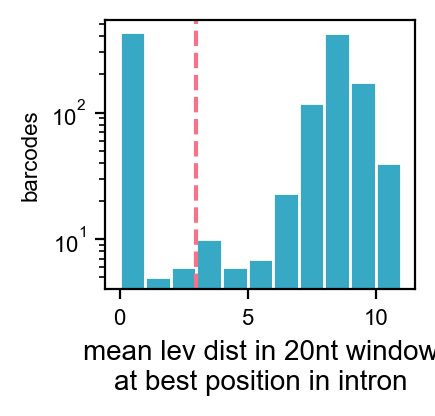

In [46]:
plt.figure(figsize=(2,1.75))
best_scores = [x[3] for x in alt_3_seqs_and_scores.values()]
plt.hist(best_scores, bins=np.arange(max(best_scores)+1), 
         edgecolor='w', facecolor=nicecolors(3))
plt.xlabel(f'mean lev dist in {window_size}nt window\nat best position in intron', fontsize=10)
plt.ylabel('barcodes')
#plt.title('what is the mean edit distance for the\nbest match position of a given barcode?')
plt.yscale('log')
plt.axvline(3,linestyle='--')
plt.show()

In [50]:
potential_alt_5ss_seqs_and_scores = {b:x for b,x in alt_3_seqs_and_scores.items() if x[3]<=2}
len(potential_alt_5ss_seqs_and_scores)

442

In [51]:
# store list for supplement
cryptic_5SS = [f'{b},{x[0]},{x[1]},{x[2]}' for b,x in alt_3_seqs_and_scores.items() if x[3]<=2]
cryptic_5SS_h = ['barcode,splice site,read count,position'] + cryptic_5SS
list_to_csv(cryptic_5SS_h, 
            outpath+'cryptic_5SS_list.csv')

## examine relationship between MaxEnt score and position for cryptic 5'SSs

In [52]:
def annotate_correlation(x, y, ax=None):
    if ax is None:
        ax = plt.gca()
    
    # Calculate Spearman correlation
    coef, p_val = stats.spearmanr(x, y)
    
    # Add the annotation
    ax.annotate(f'$\\rho$ = {coef:.3f}\n$p$-val = {p_val:.1e}', xy=(0.05, 0.05), xycoords="axes fraction", fontsize=8)
    
    # Calculate the line of best fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    # Generate x values for the line of best fit
    x_fit = np.linspace(min(x), max(x), 100)
    y_fit = slope * x_fit + intercept
    
    # Plot the line of best fit
    ax.plot(x_fit, y_fit, color='grey', linewidth=1, linestyle = '--', label='Best Fit Line')

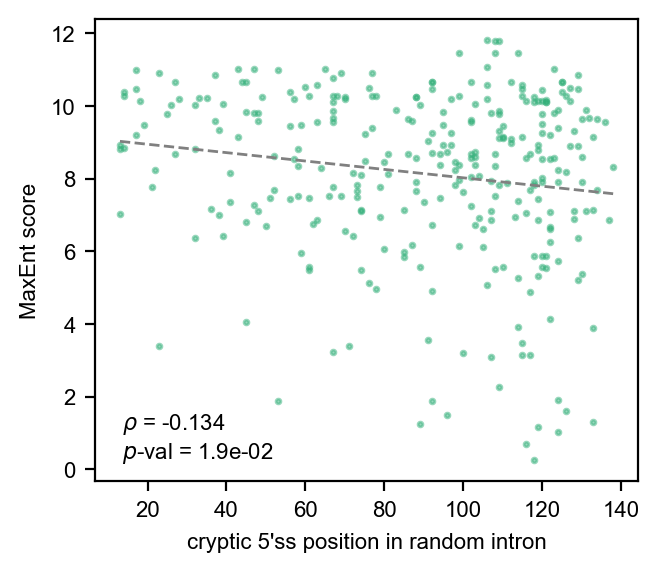

In [53]:
SS_by_pos = [(y,w) for w,x,y,z in potential_alt_5ss_seqs_and_scores.values()]

# manually got 5'SS maximum entropy score for each of these

#[print(f'>{i}\n{y}') for i,(x,y) in enumerate(SS_by_pos)]

maxents = list(pd.read_csv(outpath+'data/cryptic_5SS_maxent_scores.csv', header=None)[0])

maxent_pos_mask = np.array([x>0 for x in maxents])
poses = [x for x,y in SS_by_pos]
randomregionmask = np.array([x>12 for x in poses])

x,y = np.array(poses)[maxent_pos_mask&randomregionmask], np.array(maxents)[maxent_pos_mask&randomregionmask]

plt.figure(figsize=(3.5,3))
plt.scatter(x,y,
           s=3, alpha=0.5, color=nicecolors(2))
plt.xlabel('cryptic 5\'ss position in random intron')
plt.ylabel('MaxEnt score')
annotate_correlation(x,y)

#coef, _ = stats.spearmanr(x,y)
#plt.annotate(f'        $\\rho$ = {coef:.3f}\n$p$-val = {_:.1e}', xy=(0.6,0.05), xycoords="axes fraction", fontsize=8)

plt.show()

In [54]:
# check handedness of SSs
left_mask = [y[2]=='G' for x,y in SS_by_pos]
right_mask = [y[7]=='G' for x,y in SS_by_pos]

handedness_colors = [
    'mediumorchid' if l and r else
    'red' if l else
    'blue' if r else
    'grey'
    for l,r in zip(left_mask,right_mask)
]

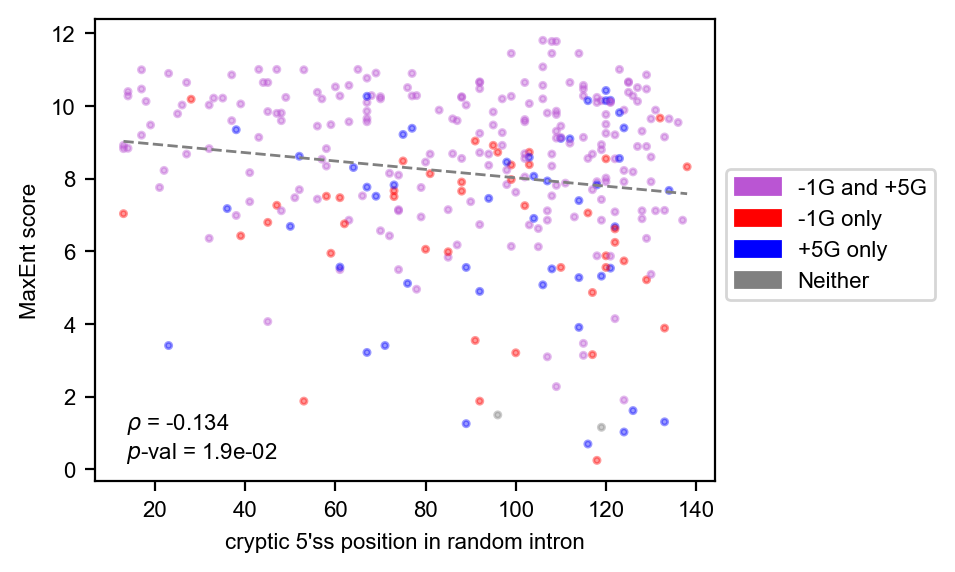

In [55]:
maxent_pos_mask = np.array([x>0 for x in maxents])
poses = [x for x,y in SS_by_pos]
randomregionmask = np.array([x>12 for x in poses])

x,y = np.array(poses)[maxent_pos_mask&randomregionmask], np.array(maxents)[maxent_pos_mask&randomregionmask]

plt.figure(figsize=(4,3))
plt.scatter(x,y,
           s=5, alpha=0.4, color=np.array(handedness_colors)[maxent_pos_mask&randomregionmask])
plt.xlabel('cryptic 5\'ss position in random intron')
plt.ylabel('MaxEnt score')

#coef, _ = stats.spearmanr(x,y)
#plt.annotate(f'$\\rho$ = {coef:.3f}\n$p$-val = {_:.1e}', xy=(0.05,0.05), xycoords="axes fraction", fontsize=8)
annotate_correlation(x,y)

# Create patches for the legend
legend_elements = [
    mpl.patches.Patch(color='mediumorchid', label='-1G and +5G'),
    mpl.patches.Patch(color='red', label='-1G only'),
    mpl.patches.Patch(color='blue', label='+5G only'),
    mpl.patches.Patch(color='grey', label='Neither')
]

# Create the legend
plt.legend(handles=legend_elements, bbox_to_anchor=(1,0.7))

plt.show()

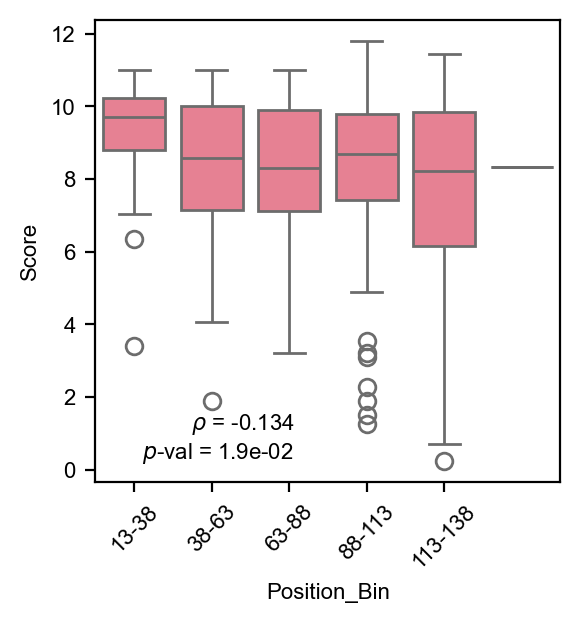

In [56]:
maxent_pos_mask = np.array([x>0 for x in maxents])
poses = [x for x,y in SS_by_pos]
randomregionmask = np.array([x>12 for x in poses])

positions = np.array(poses)[maxent_pos_mask&randomregionmask]
scores = np.array(maxents)[maxent_pos_mask&randomregionmask]

# Step 1: Bin the positions into 10 bins
bins = np.linspace(positions.min(), positions.max(), 6)
binned_positions = np.digitize(positions, bins)  # bins will be labeled from 0 to 9

# Step 2: Create a dataframe with the binned positions and the scores
df = pd.DataFrame({'Position_Bin': binned_positions, 'Score': scores})

# Step 3: Use seaborn's boxplot function to create the boxplot
plt.figure(figsize=(3, 3))
sns.boxplot(x='Position_Bin', y='Score', data=df)
bin_labels = [f'{bins[i]:.0f}-{bins[i+1]:.0f}' for i in range(len(bins)-1)]
plt.xticks(range(len(bin_labels)), bin_labels, rotation=45)
plt.ylabel('Score')
#plt.title('Score Distribution in 10 Bins of Position')

coef, _ = stats.spearmanr(x,y)
plt.annotate(f'        $\\rho$ = {coef:.3f}\n$p$-val = {_:.1e}', xy=(0.1,0.05), xycoords="axes fraction", fontsize=8)

plt.show()

## examine distribution of cryptic 5'SSs across intron

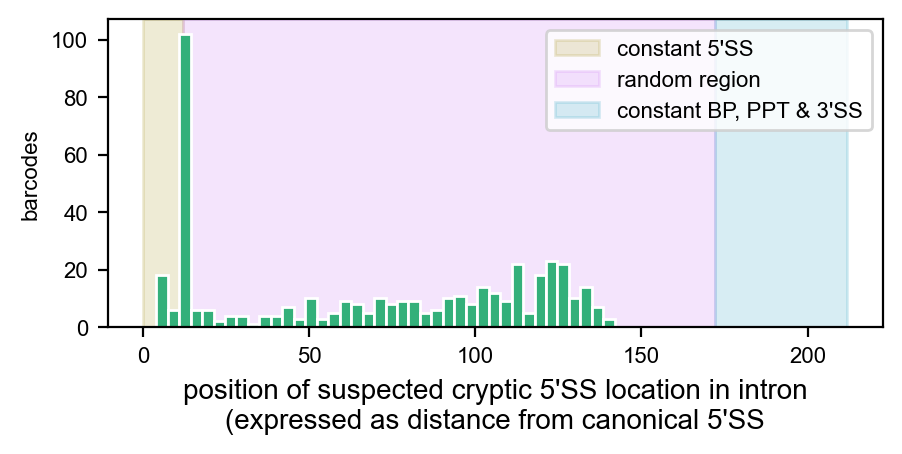

10    21
8     17
18    16
11    16
7     16
Name: count, dtype: int64

In [57]:
hist_data = [x[2]+shift for x in potential_alt_5ss_seqs_and_scores.values()]
plt.figure(figsize=(5,2))
plt.axvspan(xmin=0,xmax=12,alpha=0.2, color=nicecolors(1), label='constant 5\'SS')
plt.axvspan(xmin=12,xmax=172,alpha=0.2, color=nicecolors(4), label='random region')
plt.axvspan(xmin=172,xmax=212,alpha=0.2, color=nicecolors(3), label='constant BP, PPT & 3\'SS')
plt.hist(hist_data, bins=40, 
         edgecolor='w', facecolor=nicecolors(2))
plt.xlabel('position of suspected cryptic 5\'SS location in intron\n(expressed as distance from canonical 5\'SS', fontsize=10)
plt.ylabel('barcodes')
#plt.title('distribution of \n(for introns w one best position, at which mean lev dist <=2)', fontsize=10)
#plt.ylim(0,34)

plt.legend(fontsize=8, loc=1)
plt.show()

vcs([x[1]+shift for x in potential_alt_5ss_seqs_and_scores.values()])[:5]

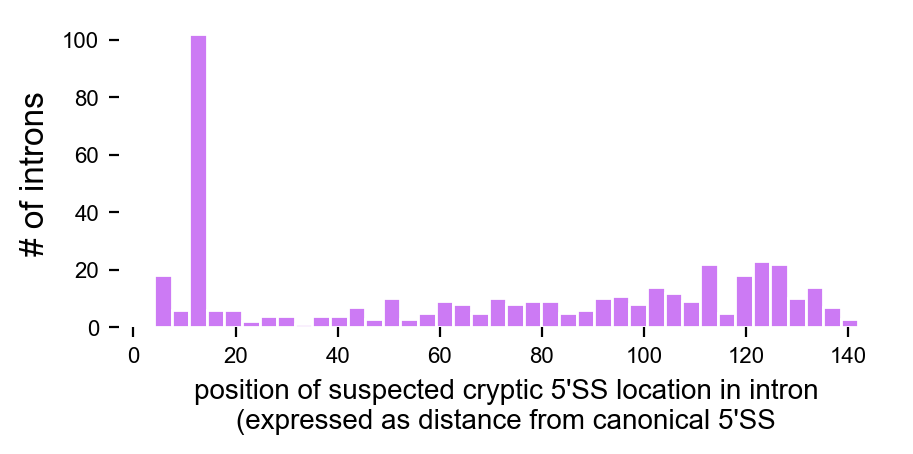

In [78]:
hist_data = [x[2]+shift for x in potential_alt_5ss_seqs_and_scores.values()]
plt.figure(figsize=(5,2))
plt.hist(hist_data, bins=40, 
         edgecolor='w', facecolor=nicecolors(4))
plt.xlabel('position of suspected cryptic 5\'SS location in intron\n(expressed as distance from canonical 5\'SS', fontsize=10)
plt.ylabel('# of introns', fontsize=12)
plt.box(False)

plt.savefig('figures/Fig4D.png', dpi=900, bbox_inches='tight')

plt.show()

In [63]:
potential_cryptic_5ss_bcs = [b for b,x in potential_alt_5ss_seqs_and_scores.items()]
plus11_5ss_bcs = [b for b,x in potential_alt_5ss_seqs_and_scores.items() if (x[2]+shift==11)]
other_cryptic_5ss_bcs = [b for b,x in potential_alt_5ss_seqs_and_scores.items() if (x[2]+shift!=11)]
plus4_bcs = [b for b,x in potential_alt_5ss_seqs_and_scores.items() if (x[2]+shift==4)]
print(len(plus11_5ss_bcs))
print(len(other_cryptic_5ss_bcs))

94
348


In [64]:
plus11_5ss = [alt_3_seqs_and_scores[b][0] for b in plus11_5ss_bcs]
other_cryptic_5ss = [alt_3_seqs_and_scores[b][0] for b in other_cryptic_5ss_bcs]
plus4_ss = [alt_3_seqs_and_scores[b][0] for b in plus4_bcs]

In [65]:
# from gpt:
import logomaker
from logomaker import transform_matrix

def sequences_to_df(sequences):
    """Convert a list of sequences into a DataFrame suitable for LogoMaker."""
    
    # Ensure all sequences are the same length
    if len(set(len(seq) for seq in sequences)) != 1:
        raise ValueError("All sequences must be of the same length.")
    
    # Initialize dictionary to store counts
    counts = {'A': [0]*len(sequences[0]), 'C': [0]*len(sequences[0]), 
              'G': [0]*len(sequences[0]), 'T': [0]*len(sequences[0])}
    
    # Count each nucleotide at each position
    for seq in sequences:
        for i, nucleotide in enumerate(seq):
            if nucleotide in counts:
                counts[nucleotide][i] += 1
    
    # Convert the dictionary to a DataFrame
    df = pd.DataFrame(counts)

    info_df = transform_matrix(df, from_type='counts', to_type='information')
    
    return info_df

def set_5SS_xticks(ss_logo):
    ss_logo.ax.set_xticks(range(9))
    ss_logo.ax.set_xticklabels('%+d'%x for x in [-3, -2, -1, 1, 2, 3, 4, 5, 6])
    ss_logo.ax.set_ylim(0,2)

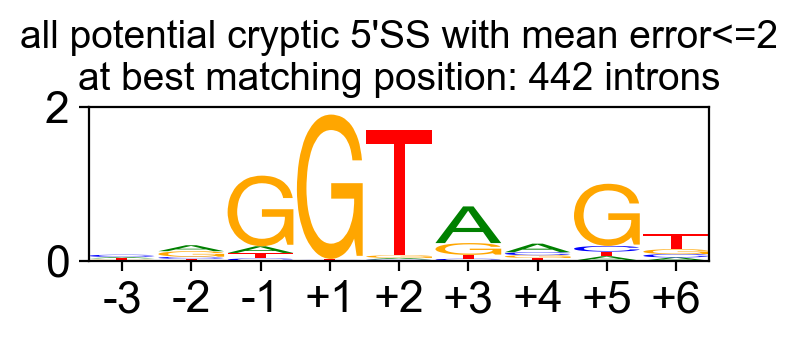

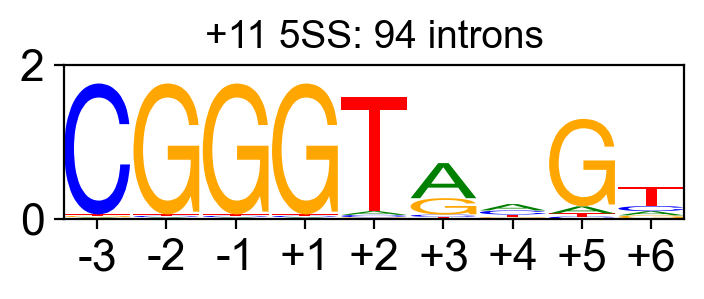

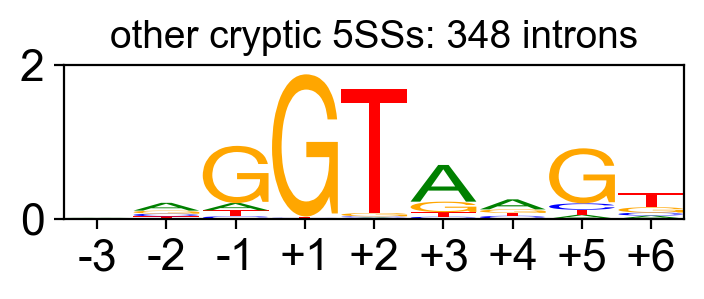

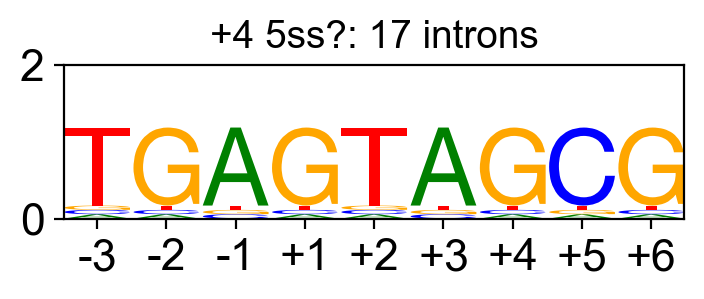

In [69]:
SS_sets = [(plus11_5ss+other_cryptic_5ss),plus11_5ss,other_cryptic_5ss, plus4_ss]
SS_set_names = ['all potential cryptic 5\'SS with mean error<=2\nat best matching position','+11 5SS','other cryptic 5SSs', '+4 5ss?']

for setname, SS_set in zip(SS_set_names,SS_sets):
    ss_logo = logomaker.Logo(sequences_to_df(SS_set), figsize=(4,1))
    set_5SS_xticks(ss_logo)
    ss_logo.ax.set_title(f'{setname}: {len(SS_set)} introns', fontsize=14)
    ss_logo.ax.tick_params(axis='x', labelsize=16)  # Adjust font size for x-axis tick labels
    ss_logo.ax.tick_params(axis='y', labelsize=16)  # Adjust font size for y-axis tick labels 
    plt.savefig('figures/Fig4_5SSlogos_'+setname+'.png', dpi=900, bbox_inches='tight')

# Apply the same strategy to identify cryptic 3'SSs

In [70]:
# get dict of all unexpected 5' end seqs

alt_5_seqs = {bc:[] for bc in RIL2_unspliced}

for bc, dlist in RIL2_unspliced_dists.items():
    # save any 3'end seqs (the 44 nucleotides in the intron) that do not match expected seq
    alt_seqs = [s[1][16:] for i,s in enumerate(RIL2_unspliced[bc]) if dlist[i][0] > tol5]
    alt_5_seqs[bc].append(alt_seqs)
    
for b in RIL2_unspliced:
    alt_5_seqs[b] = flatten(alt_5_seqs[b])
    if len(alt_5_seqs[b])==0:
        del alt_5_seqs[b]   

starting with 143446 reads from 3875 barcodes that have any unspliced reads with unexpected intron 5' end seq
2474 of these have at least 2 reads that do not have the constant 5'SS for the library
checking for potential alternative 3'SSs...


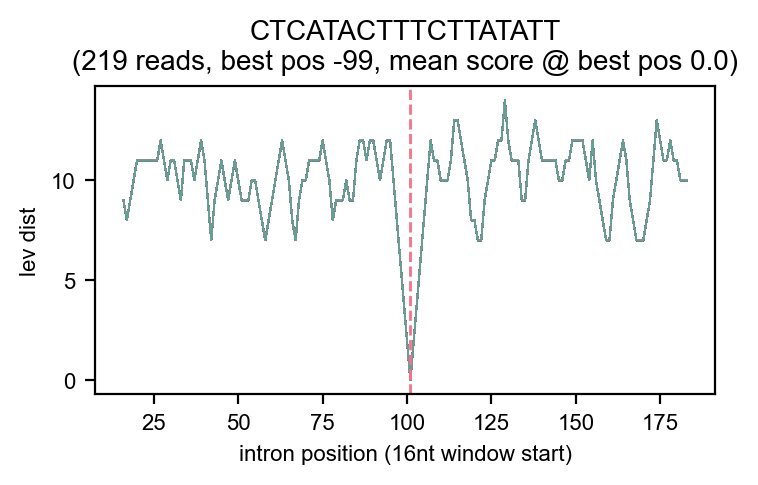

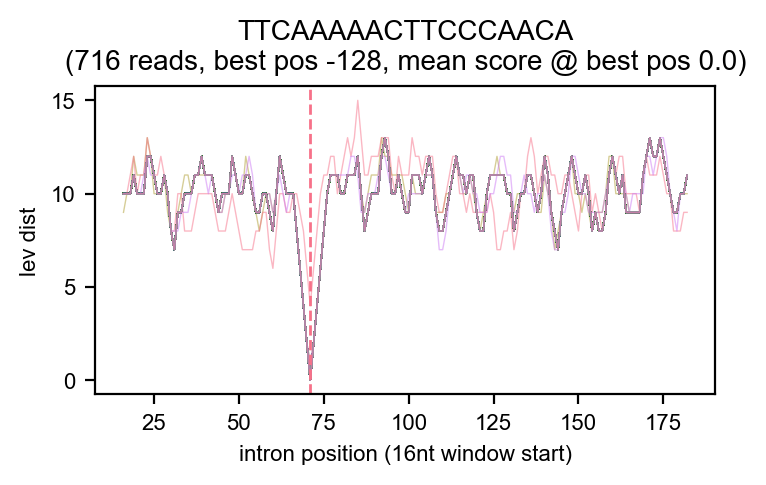

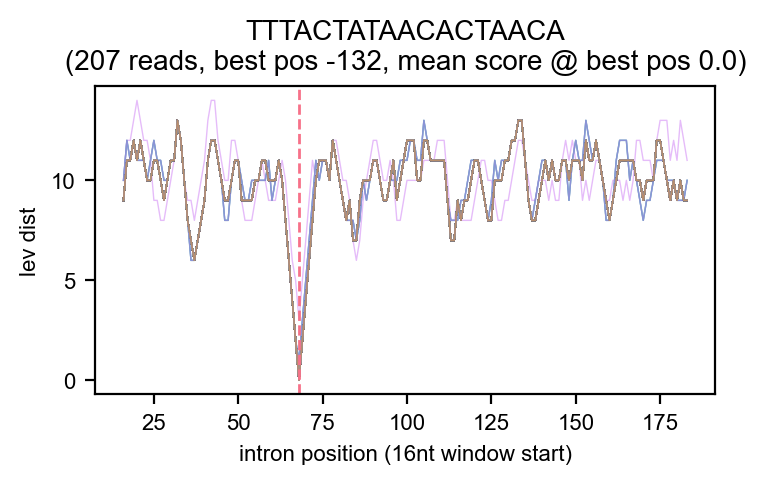

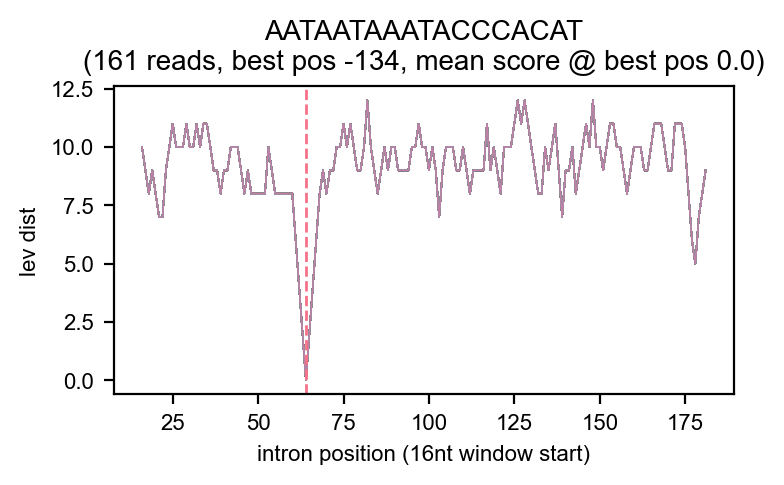

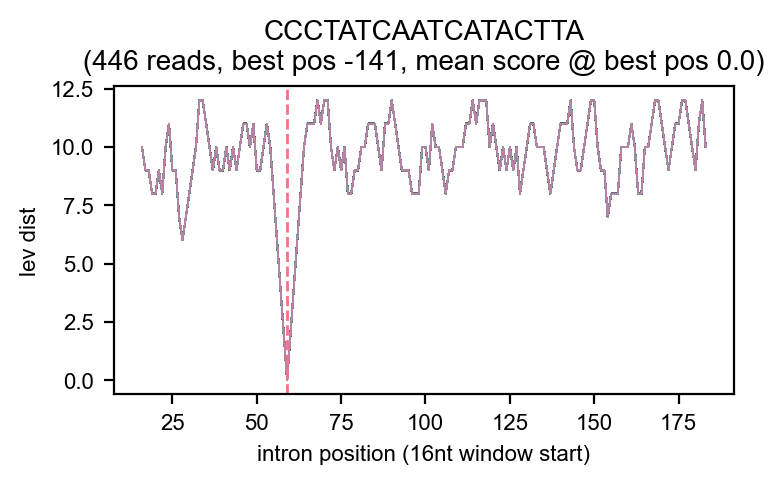

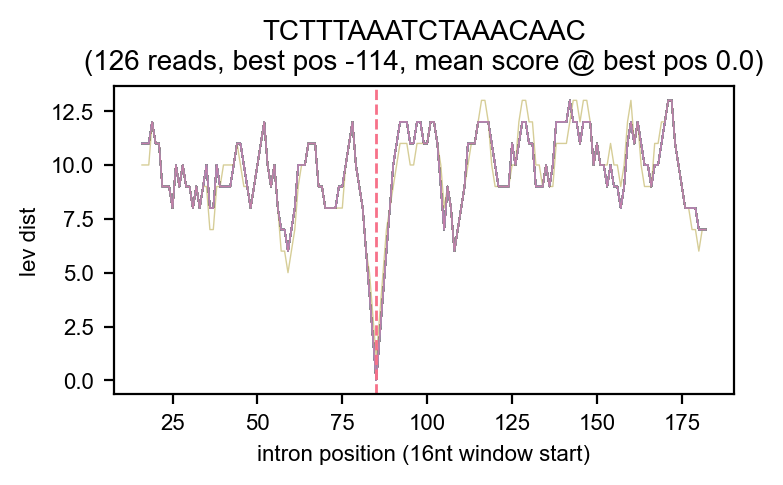

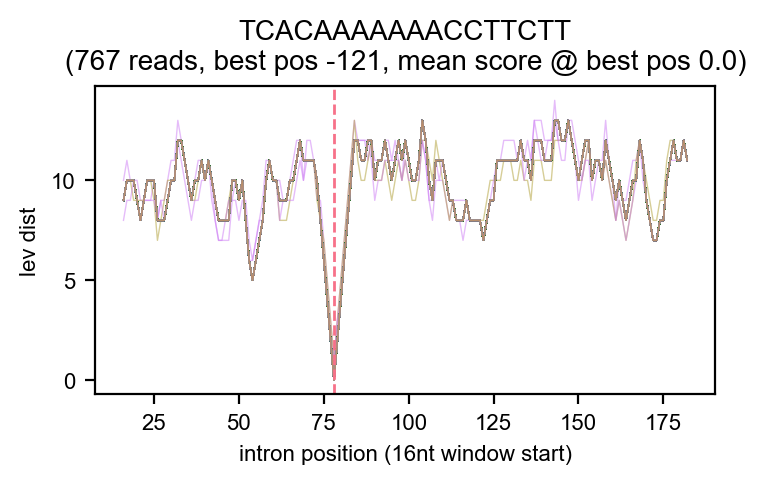

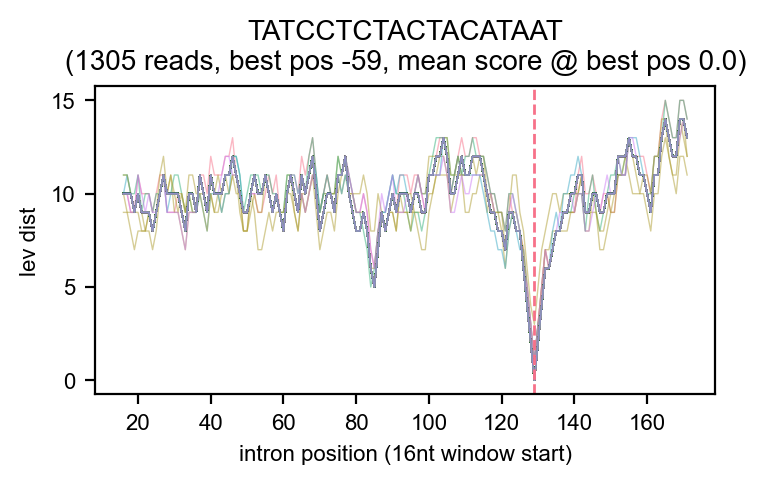

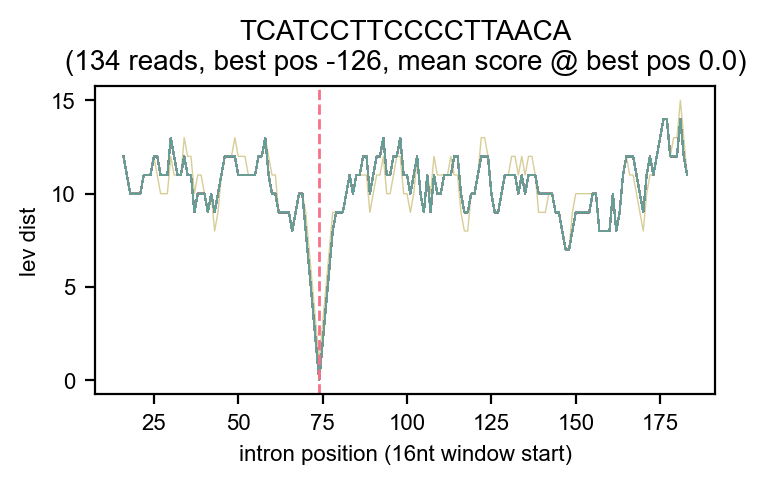

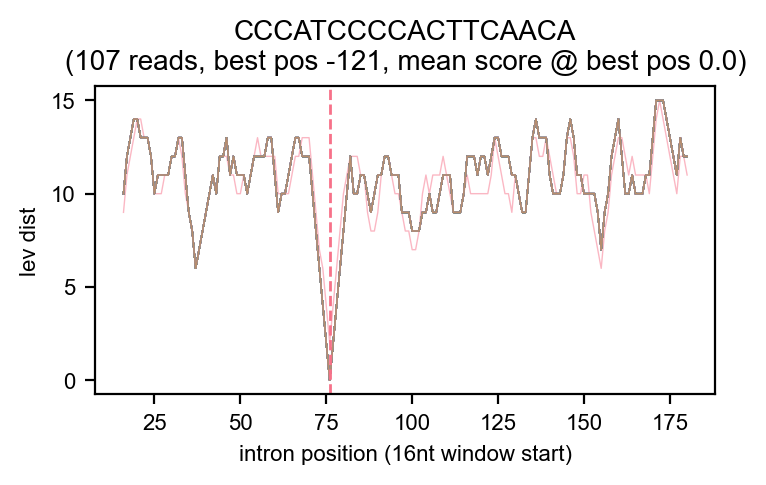

1078 of these barcodes have a single position in the intron that seems to be used as an alternative 3'SS


In [82]:
# take the n bases of intron from read and scan across the predicted intron to see lev distances with any given window

# length of read to use to scan along intron for homology
window_size = 16    # this is the maximum possible window size if the canonical 5'SS is used
exon1 = 'TGATCGTCGTCACCAG'    #add 16nt upstream exon seq to allow for possibility of SS in this region
exon2 = 'GTGTCGTGAA'    # same logic at 3' end
#shift = -1    # not sure why this works but it does, i think one-off since anchoring window at 3'end?
plotted=0

# we only care if 2 or more of reads for that barcode are unexpected
bcs_of_interest = [b for b,l in alt_5_seqs.items() if len(l)>1]
alt_5_seqs_and_scores = {b:None for b in bcs_of_interest}

print(f'starting with {len(flatten([x for x in alt_5_seqs.values()]))} reads from {len(alt_5_seqs)} barcodes that have any unspliced reads with unexpected intron 5\' end seq')
print(f'{len(bcs_of_interest)} of these have at least 2 reads that do not have the constant 5\'SS for the library')
print('checking for potential alternative 3\'SSs...')

# iterate through barcodes and assoc. reads that have unexpected 3'SS seqs
for b in bcs_of_interest:
    rlist = alt_5_seqs[b]
    intseq = b2i[b].upper()[12:]
    positions = np.arange(window_size,len(intseq)-window_size)
    intlenshift = len(intseq)-212    # pos is relative to 3' end; shift to account for variable intron length
    
    # set up containers to collect info for each barcode
    position_scores = []
    best_positions = []
    best_scores = []

    # take last n bases of intron from each seq read
    for r in rlist:
        pos_dists = []
        intread = r[:window_size]

        # scan this along expected intron and see how it matches up
        # STARTING AT 3' END
        for pos in positions:
            pos_dists.append((lev(intread, intseq[pos:pos+window_size])))

        # plot these dists for each read, store list of dists & minimum dist            
        if (len(pos_dists))>0:
            position_scores.append(pos_dists)
            best_positions.append(pos_dists.index(min(pos_dists))+window_size)
            best_scores.append(min(pos_dists))

    # if there is one position that all reads point to as the best match, save it
    if len(set(best_positions))==1:
        best_bet = best_positions[0]-len(intseq)    # store as distance from 3' end
        best_bet_mean_score = round(np.mean(best_scores), 2)

    # extract seq from intron
        potential_alt_3SS = (exon1+intseq)[best_bet-20:best_bet+3]
        alt_5_seqs_and_scores[b] = (potential_alt_3SS, len(rlist), best_bet, best_bet_mean_score)

        # plot scores along intron for a few example reads:
        
        if plotted<10:
            if (len(rlist)>100)&(best_bet_mean_score<=3):
                plt.figure(figsize=(4,2)) 
                for s in position_scores:
                    three_end_anchored_positions = np.array(positions)   
                    plt.plot(three_end_anchored_positions, s, linewidth=0.5, alpha=0.5)
                plt.axvline(best_bet+len(intseq), linewidth=1, linestyle='--')
                plt.title(f'{b}\n({len(rlist)} reads, best pos {best_bet}, mean score @ best pos {best_bet_mean_score:.1f})',
                         fontsize=10)
                plt.ylabel('lev dist')
                plt.xlabel(f'intron position ({window_size}nt window start)')
                #plt.xlim(2,200-window_size+10)
                plt.show()
                plotted+=1
    
    elif len(set(best_positions))!=1:
        del alt_5_seqs_and_scores[b]

print(f'{len(alt_5_seqs_and_scores)} of these barcodes have a single position in the intron that seems to be used as an alternative 3\'SS')

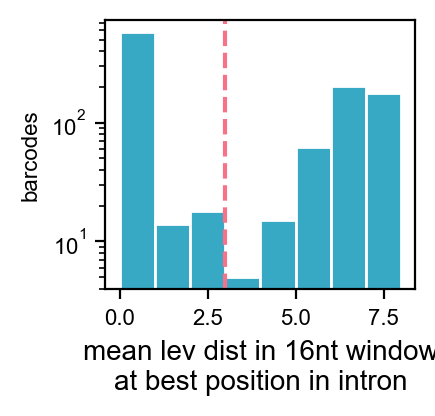

In [83]:
plt.figure(figsize=(2,1.75))
best_scores = [x[3] for x in alt_5_seqs_and_scores.values()]
plt.hist(best_scores, bins=np.arange(max(best_scores)+1), 
         edgecolor='w', facecolor=nicecolors(3))
plt.xlabel(f'mean lev dist in {window_size}nt window\nat best position in intron', fontsize=10)
plt.ylabel('barcodes')
plt.yscale('log')
plt.axvline(3,linestyle='--')
plt.show()

In [84]:
potential_alt_3ss_seqs_and_scores = {b:x for b,x in alt_5_seqs_and_scores.items() if x[3]<=2}
len(potential_alt_3ss_seqs_and_scores)

609

In [85]:
# store list for supplement 
cryptic_3SS = [f'{b},{x[0]},{x[1]},{x[2]}' for b,x in alt_5_seqs_and_scores.items() if x[3]<=2]
cryptic_3SS_h = ['barcode,splice site,read count,position'] + cryptic_3SS
list_to_csv(cryptic_3SS_h, 
            outpath+'cryptic_3SS_list.csv')

## examine relationship between MaxEnt score and position for cryptic 3'SSs

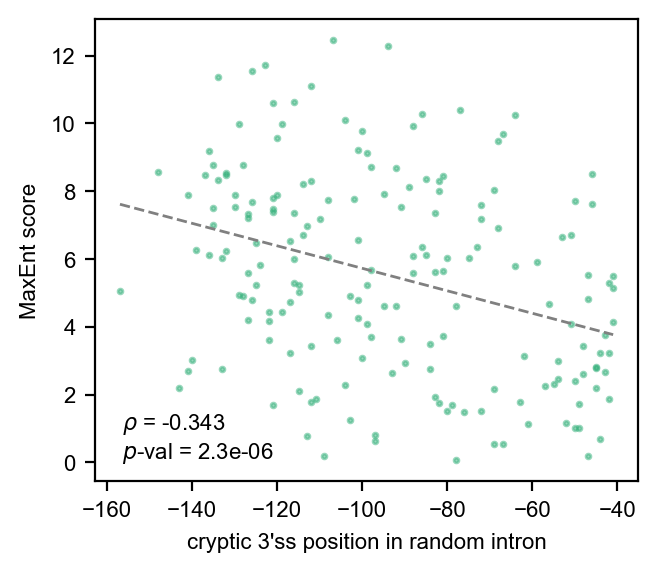

In [88]:
SS_by_pos = [(y,w) for w,x,y,z in potential_alt_3ss_seqs_and_scores.values()]

# manually got 3'SS maximum entropy score for each of these

#ss_fasta_3 = flatten([[(f'>{i}'),(f'{y}')] for i,(x,y) in enumerate(SS_by_pos)])
#list_to_csv(ss_fasta_3, outpath+'data/cryptic_3SSs.fa')
maxents_raw = list(pd.read_csv(outpath+'data/maxent3output.txt', header=None)[0])
maxents = [float(x.split('\t')[1].split(' ')[1]) for x in maxents_raw[1::2]]

maxent_pos_mask = np.array([x>0 for x in maxents])
poses = [x for x,y in SS_by_pos]
randomregionmask = np.array([x<-40 for x in poses])

x,y = np.array(poses)[maxent_pos_mask&randomregionmask], np.array(maxents)[maxent_pos_mask&randomregionmask]

plt.figure(figsize=(3.5,3))
plt.scatter(x,y,
           s=3, alpha=0.5, color=nicecolors(2))
plt.xlabel('cryptic 3\'ss position in random intron')
plt.ylabel('MaxEnt score')
annotate_correlation(x,y)

#coef, _ = stats.spearmanr(x,y)
#plt.annotate(f'        $\\rho$ = {coef:.3f}\n$p$-val = {_:.1e}', xy=(0.6,0.05), xycoords="axes fraction", fontsize=8)

plt.show()

## examine distribution of cryptic 3'SSs across intron

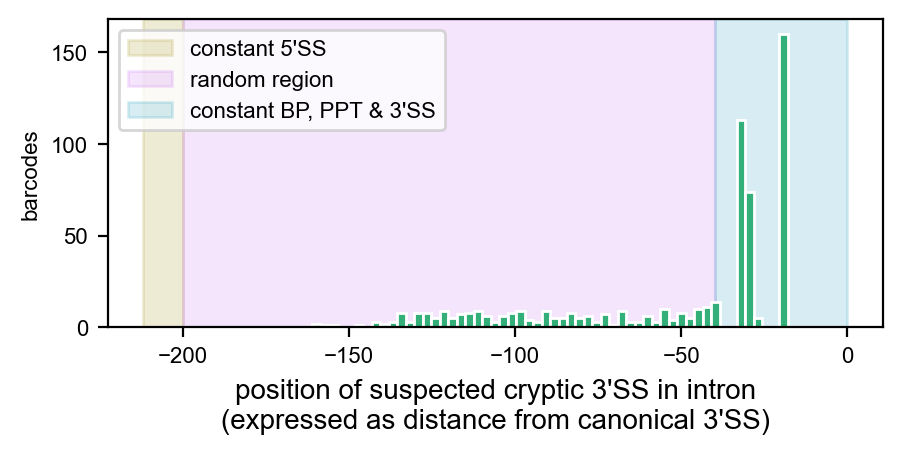

In [86]:
hist_data = [x[2] for bc,x in potential_alt_3ss_seqs_and_scores.items()]
plt.figure(figsize=(5,2))
plt.axvspan(xmin=-212,xmax=-200,alpha=0.2, color=nicecolors(1), label='constant 5\'SS')
plt.axvspan(xmin=-200,xmax=-40,alpha=0.2, color=nicecolors(4), label='random region')
plt.axvspan(xmin=-40,xmax=0,alpha=0.2, color=nicecolors(3), label='constant BP, PPT & 3\'SS')
plt.hist(hist_data, bins=56,
         edgecolor='w', facecolor=nicecolors(2))
plt.xlabel('position of suspected cryptic 3\'SS in intron\n(expressed as distance from canonical 3\'SS)', fontsize=10)
plt.ylabel('barcodes')
plt.legend(fontsize=8, loc=2)
plt.show()

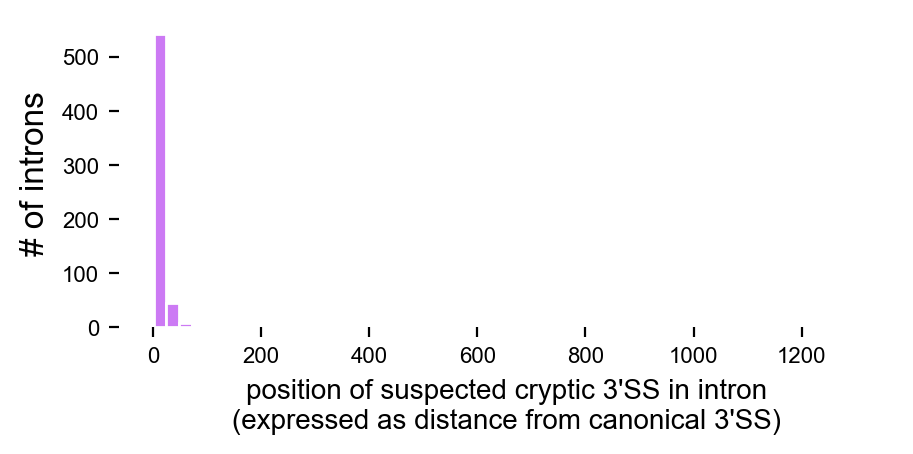

In [87]:
hist_data = [x[1] for bc,x in potential_alt_3ss_seqs_and_scores.items()]
plt.figure(figsize=(5,2))
plt.hist(hist_data, bins=56, 
         edgecolor='w', facecolor=nicecolors(4))
plt.xlabel('position of suspected cryptic 3\'SS in intron\n(expressed as distance from canonical 3\'SS)', fontsize=10)
plt.ylabel('# of introns', fontsize=12)
plt.box(False)

plt.savefig('figures/Fig4F.png', dpi=900, bbox_inches='tight')

plt.show()

In [91]:
potential_cryptic_3ss_bcs = [bc for bc,(w,x,y,z) in potential_alt_3ss_seqs_and_scores.items()]
potential_cryptic_3ss = [w for w,x,y,z in potential_alt_3ss_seqs_and_scores.values()]
potential_cryptic_3ss_193 = [w for w,x,y,z in potential_alt_3ss_seqs_and_scores.values() if (y==-19)]
potential_cryptic_3ss_other = [w for w,x,y,z in potential_alt_3ss_seqs_and_scores.values() if (y!=-19)]

In [92]:
list_to_csv(potential_cryptic_3ss,outpath+'potential_cryptic_3ss_seqs.txt')

In [81]:
print('      *   *         *')
print(threeSS_seq)

      *   *         *
GCCTCAGACAGTGGTTCAAAGTTTTTTTCTTCCATTTCAG


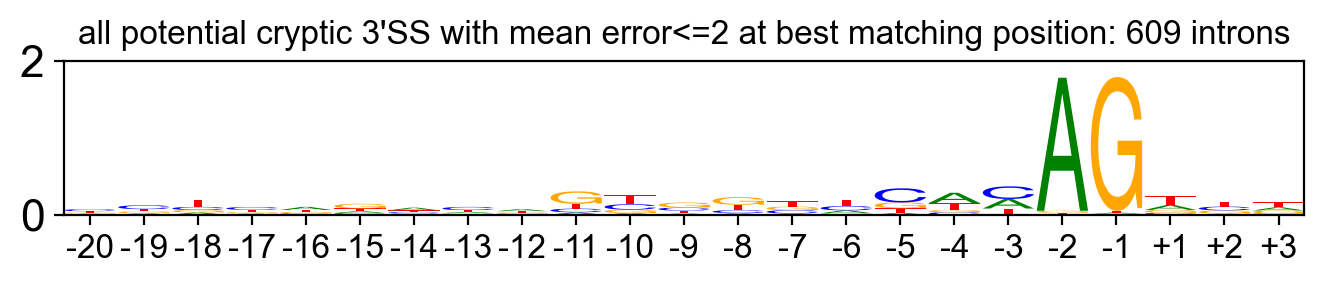

In [95]:
def set_3SS_xticks(ss_logo):
    ss_logo.ax.set_xticks(range(23))
    ss_logo.ax.set_xticklabels('%+d'%x for x in [-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,
                                                 -9,-8,-7,-6,-5,-4,-3,-2,-1, 1, 2, 3])
    ss_logo.ax.set_ylim(0,2)

SS_sets = [potential_cryptic_3ss,#potential_cryptic_3ss_193,potential_cryptic_3ss_other
          ]
SS_set_names = ['all potential cryptic 3\'SS with mean error<=2 at best matching position',
                #'+193 3\'SS','other cryptic 3\'SSs'
               ]

for setname, SS_set in zip(SS_set_names,SS_sets):
    ss_logo = logomaker.Logo(sequences_to_df([x for x in SS_set if len(x)>0]),
                            figsize=(8,1))
    set_3SS_xticks(ss_logo)
    ss_logo.ax.set_title(f'{setname}: {len(SS_set)} introns', fontsize=12)
    ss_logo.ax.tick_params(axis='x', labelsize=12)  # Adjust font size for x-axis tick labels
    ss_logo.ax.tick_params(axis='y', labelsize=16)  # Adjust font size for y-axis tick labels
    plt.savefig('figures/Fig4_3SSlogo.png', dpi=900, bbox_inches='tight')
